In [1]:
import argparse
import numpy as np
import os
import tabulate
import torch
import torch.nn.functional as F
import torch.nn

import data
import models
import curves
import utils

import pickle
from pylab import rcParams

from sklearn import datasets
import multiprocessing
from sklearn.decomposition import PCA

import scipy
from scipy.stats import norm

In [2]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from scipy.stats import norm

import utils
import time
from torch import nn
import seaborn as sns
from sklearn.manifold import TSNE

In [78]:
class distribution():
    def __init__(self, X):
        self.sorted_X = np.sort(X)
        self.uniform = np.arange(len(X)+1)/len(X)
        
    
    def F(self, x):
        b = self.sorted_X>=x
        ind = np.argmax(b)
#         print(ind)
#         print(b)
        if ~b[-1] and ind==0:
            return 1
        elif b[0] and ind==0:
            return 0
        else:
            delta = (x-self.sorted_X[ind-1])/(self.sorted_X[ind]-self.sorted_X[ind-1])
            return self.uniform[ind]+delta*(1/len(self.sorted_X))

    def inv_F(self, u):
        
        b = self.uniform[1:]>=u
        ind = np.argmax(b)
        if b[-1] and ind==(len(self.sorted_X)-1):
            return self.sorted_X[-1]
        elif b[0] and ind==0:
            return self.sorted_X[0]
        else:
            delta = (u-self.uniform[ind])/(1/len(self.sorted_X))
            return self.sorted_X[ind-1]+delta*(self.sorted_X[ind]-self.sorted_X[ind-1])


In [102]:
def show_samples(point1, point2, result, show="hex", limits=True):
    if show == "points":
        rcParams['figure.figsize'] = 16, 6
        fig, axes = plt.subplots(1, 3,)
        if limits:
            for a in axes:
                a.set_xlim([point1[:,0].min(), point1[:,0].max()])
                a.set_ylim([point1[:,1].min(), point1[:,1].max()])
        axes[0].set_title('Samples 1')
        axes[0].scatter(point1[:, 0], point1[:, 1])
        axes[1].set_title('Result')
        axes[1].scatter(result[:, 0], result[:, 1])
        axes[2].set_title('Samples 2')
        axes[2].scatter(point2[:, 0], point2[:, 1])
        plt.show()
    elif show == "hex":
        rcParams['figure.figsize'] = 16, 6
        fig, axes = plt.subplots(1, 3,)
        if limits:
            for a in axes:
                a.set_xlim([point1[:,0].min(), point1[:,0].max()])
                a.set_ylim([point1[:,1].min(), point1[:,1].max()])
        axes[0].set_title('Samples 1')
        axes[0].hexbin(point1[:, 0], point1[:, 1], gridsize=10, cmap=plt.cm.BuGn_r)
        axes[1].set_title('Result')
        axes[1].hexbin(result[:, 0], result[:, 1], gridsize=10, cmap=plt.cm.BuGn_r)
        axes[2].set_title('Samples 2')
        axes[2].hexbin(point2[:, 0], point2[:, 1], gridsize=10, cmap=plt.cm.BuGn_r)
        plt.show()
    elif show == "kde":
        rcParams['figure.figsize'] = 8, 6
        fig, axes = plt.subplots(1, 1,)
        if limits:
                axes.set_xlim([point1[:,0].min(), point1[:,0].max()])
                axes.set_ylim([point1[:,1].min(), point1[:,1].max()])
        sns.kdeplot(point1[:, 0], point1[:, 1], shade=True,  cbar=True)
        plt.show()
        sns.kdeplot(result[:, 0], result[:, 1], shade=True,  cbar=True)
        plt.show()
        sns.kdeplot(point2[:, 0], point2[:, 1], shade=True,  cbar=True)
        plt.show()
        


In [190]:
def f(Z):
    X, All = Z
    distr = distribution(All)
    u = []
    for x in X:
        u.append(distr.F(x))
        
    return np.array(u)

def g(Z):
    
    X, U = Z
    distr = distribution(X)
    u = []
    for x in U:
        u.append(distr.inv_F(x))
        
    return  np.array(u)

In [247]:
noisy_circles = [datasets.make_circles(n_samples=1000, factor=.5, noise=.05)[0] for _ in range(2)]
noisy_moons = [datasets.make_moons(n_samples=1000, noise=.05)[0] for _ in range(2)]
# noisy_normals = [datasets.make_gaussian_quantiles(n_samples=1000, n_classes=1)[0] for _ in range(2)]
noisy_normals = [np.random.multivariate_normal(mean=[0, 0], cov=[[1,0], [0, 1]], size=1000) for _ in range(2)] 

In [248]:
for noisy_normal in noisy_normals:
    noisy_normal[:, 0] -= 0.5*noisy_normal[:, 1]*noisy_normal[:, 1]
    

# for noisy_normal in noisy_normals:
#     noisy_normal[:, 0] += 0.5*noisy_normal[:, 0]*noisy_normal[:, 1]
    
# for noisy_normal in noisy_normals:
#     noisy_normal[:, 0] += 0.5*noisy_normal[:, 0]*noisy_normal[:, 0]

def tr(S1, S2, use_mean=True, use_PSA=True, use_std=True, K=2):
    S = np.vstack([S1, S2])
    
    if use_mean:
        mean = S.mean(0)
        S = S-mean
        S1 = S1-mean
        S2 = S2-mean
    
    if use_PSA:
        K = K
        transPSA = PCA(n_components = K)
        S = transPSA.fit_transform(S)
        S1 = transPSA.transform(S1)
        S2 = transPSA.transform(S2)

    if use_std:
        std = S.std(0)
        S = S/std
        S1 = S1/std
        S2 = S2/std
        
    return [S1, S2]
        
noisy_normals = tr(*noisy_normals)


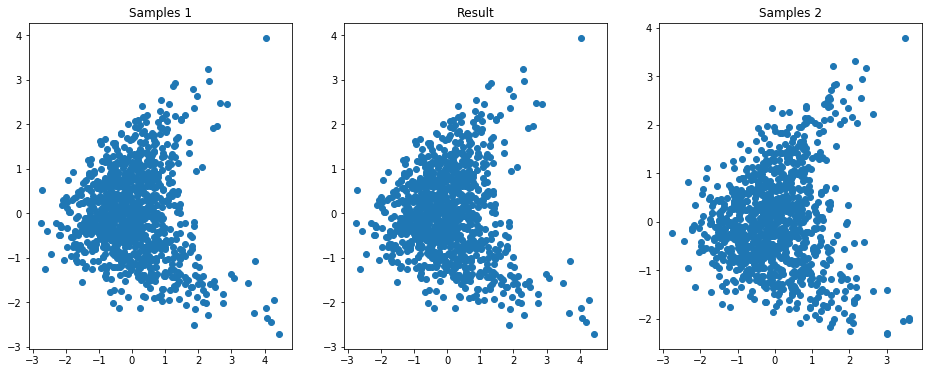

In [249]:
show_samples(*noisy_normals, noisy_normals[0], show='points', limits=False)

In [250]:
noisy_normals[0].mean(0)

array([-0.00828453,  0.00150226])

In [251]:
noisy_normals[0].T @ noisy_normals[0]/ len(noisy_normals[0])

array([[ 1.05493096, -0.06426882],
       [-0.06426882,  0.96849799]])

In [281]:
def compute_3cumulant(S):
    
    S_centered = S-S.mean(0)
    pre_cov = np.expand_dims(S_centered, axis=-1)@ np.expand_dims(S_centered, axis=1)
    third_cumulants = []

    for i in range(S.shape[1]):
        third_cumulants1 = pre_cov.T[i] @ S_centered
        third_cumulants.append(third_cumulants1)

    return np.array(third_cumulants)/len(S)

def transform(S1, S2, use_PSA=True, use_one=True, show=True, use_std=True, inverse=True, 
             use_third_cumulant=True, t=0.5, show_type='kde', K=2, use_mean=True, limits=True):
    

    S = np.vstack([S1, S2])
    SI1 = S1
    SI2 = S2
    SI = S
    
    if use_mean:
        mean = S.mean(0)
        S = S-mean
        S1 = S1-mean
        S2 = S2-mean
    
    if use_PSA:
        K = K
        transPSA = PCA(n_components=K)
        S = transPSA.fit_transform(S)
        S1 = transPSA.transform(S1)
        S2 = transPSA.transform(S2)

    if use_std:
        std = S.std(0)
        S = S/std
        S1 = S1/std
        S2 = S2/std
        
    if inverse:
        
        if use_one:
            TR1 = S
            TR2 = S
            TRF = S
        else:
            TR1 = S1
            TR2 = S2
            TRF = S
        
        pool = multiprocessing.Pool(200)
        res1 = np.array(pool.map(f, zip(S1.T, TR1.T))).T
        res2 = np.array(pool.map(f, zip(S2.T, TR2.T))).T

        rv = norm()

        nres1 = np.clip(rv.ppf(res1), -10, 10)
        nres2 =  np.clip(rv.ppf(res2), -10, 10)
    else:
        nres1, nres2 = S1, S2
        
    if use_third_cumulant:
        third_cumulants = compute_3cumulant(S)
    
    a = np.cos(np.pi*t/2)
    b = np.sin(np.pi*t/2)
    nfin = a*nres1+b*nres2
    
    print(nfin.mean(0))
    print(nfin.T@nfin/1000)
    
    if use_third_cumulant:
        delta = []
        for n1 in range(S.shape[1]):
#             first = (np.diag(third_cumulants[n1])*(1-a-b)).sum(0) 
            first = 0
            for n2 in range(S.shape[1]):
                first += third_cumulants[n1, n2, n2]*(1-a-b)
            second = 0
            for n2 in range(S.shape[1]):
                for n3 in range(S.shape[1]):
                        vsp = (a*nres1[:, n2]+b*nres2[:, n2])*(a*nres1[:, n3]+b*nres2[:, n3])
                        -a*nres1[:, n2]*nres1[:, n3]-b*nres2[:, n2]*nres2[:, n3]
                        second +=  third_cumulants[n1, n2, n3]*vsp

            delta.append((1/6)*(-first+second))
        delta = np.array(delta).T

        nfin = nfin+delta
        
    print(nfin.mean(0))
    print(nfin.T@nfin/1000)    
        
    if inverse:
        ufin = rv.cdf(nfin)
        fin = np.array(pool.map(g, zip(TRF.T, ufin.T))).T
    else:
        fin = nfin
    
    if use_std:
        fin = std*fin
    
    if use_PSA:
        fin = transPSA.inverse_transform(fin)
    
    if use_mean:
        fin +=mean
    
    show_samples(SI1, SI2, fin, show=show_type, limits=limits)
    
    if show and inverse:
        ind = 0
        rcParams['figure.dpi'] = 50
        plt.hist(SI2[:, ind], bins=30);
        plt.show()
        plt.hist(res2[:, ind], bins=30);
        plt.show()
        plt.hist(nres2[:, ind], bins = 50);
        plt.show()
        plt.hist(nfin[:, ind], bins = 50); 
        plt.show()
        plt.hist(ufin[:, ind], bins = 50); 
        plt.show()
        plt.hist(fin[:, ind], bins = 50);  
        plt.show()
        
    return fin, third_cumulants, compute_3cumulant(S1), compute_3cumulant(S2), S1.mean(0), S2.mean(0),  S1.T@S1, S2.T@S2

# Simple Arc

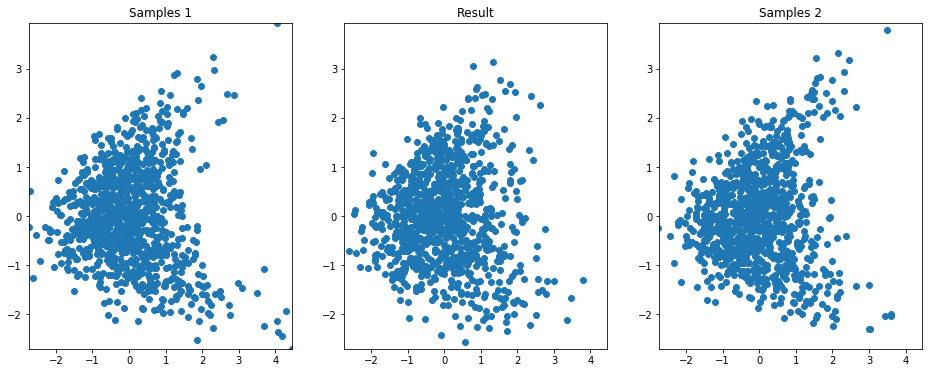

In [253]:
result = transform(*noisy_normals, use_PSA=False, use_one=False, inverse=False, 
                   use_third_cumulant=False, use_std=True, 
                   show_type="points")

# Simple Arc with third cumulant

[-2.66453526e-18 -9.54791801e-18]
[[ 1.01436496 -0.01749683]
 [-0.01749683  0.96676593]]
[0.28367317 0.01564769]
[[ 1.36569833 -0.13712662]
 [-0.13712662  1.32577265]]


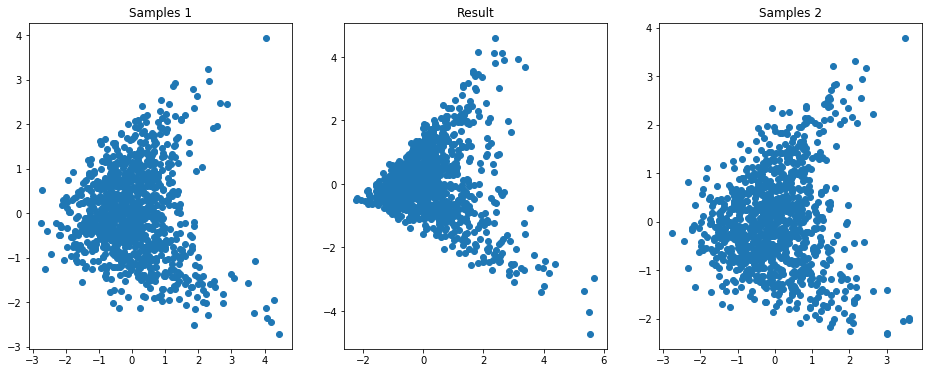

In [282]:
# result = transform(*noisy_moons, use_PSA=False, use_one=True, use_std=True, inverse=True, use_third_cumulant=True)
# result = transform(*noisy_circles, use_PSA=True, use_one=True, inverse=True, use_third_cumulant=True)
result, third_cumulants_res, compute_3cumulant_S1, compute_3cumulant_S2, mean1, mean2, cov1, cov2 = transform(*noisy_normals, use_PSA=False, use_one=False, inverse=False, 
                   use_third_cumulant=True, use_std=False, use_mean=False, limits=False,
                   show_type="points", K=2)

In [260]:
third_cumulants_res, 

(array([[[ 0.49804314, -0.24721423],
         [-0.24721423,  0.71101297]],
 
        [[-0.24721423,  0.71101297],
         [ 0.71101297,  0.34173717]]]),)

In [261]:
compute_3cumulant_S1

array([[[ 0.71971456, -0.38438186],
        [-0.38438186,  0.71883326]],

       [[-0.38438186,  0.71883326],
        [ 0.71883326,  0.23049128]]])

In [262]:
compute_3cumulant_S2

array([[[ 0.27910219, -0.11234138],
        [-0.11234138,  0.70305692]],

       [[-0.11234138,  0.70305692],
        [ 0.70305692,  0.453267  ]]])

In [263]:
(compute_3cumulant_S2+compute_3cumulant_S1)/2

array([[[ 0.49940837, -0.24836162],
        [-0.24836162,  0.71094509]],

       [[-0.24836162,  0.71094509],
        [ 0.71094509,  0.34187914]]])

In [265]:
noisy_normals[0].mean(0), noisy_normals[1].mean(0), result.mean(0),

(array([-0.00828453,  0.00150226]),
 array([ 0.00828453, -0.00150226]),
 array([0.28367317, 0.01564769]))

In [270]:
mean1, mean2, result.mean(0)

(array([-0.00828453,  0.00150226]),
 array([ 0.00828453, -0.00150226]),
 array([0.28367317, 0.01564769]))

In [277]:
print(cov1/1000) 
print(cov2/1000) 
print(result.T@result/1000)

[[ 1.05493096 -0.06426882]
 [-0.06426882  0.96849799]]
[[0.94506904 0.06426882]
 [0.06426882 1.03150201]]
[[ 1.36569833 -0.13712662]
 [-0.13712662  1.32577265]]


# Arc with inverse

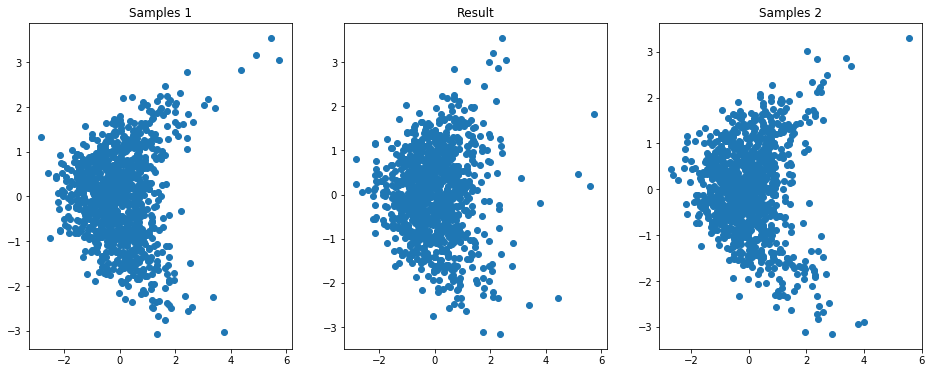

In [204]:
result = transform(*noisy_normals, use_PSA=False, use_one=True, inverse=True, 
                   use_third_cumulant=False, use_std=False, 
                   show_type="points", show=False, limits=False)

# Arc with inverse and third cumulant

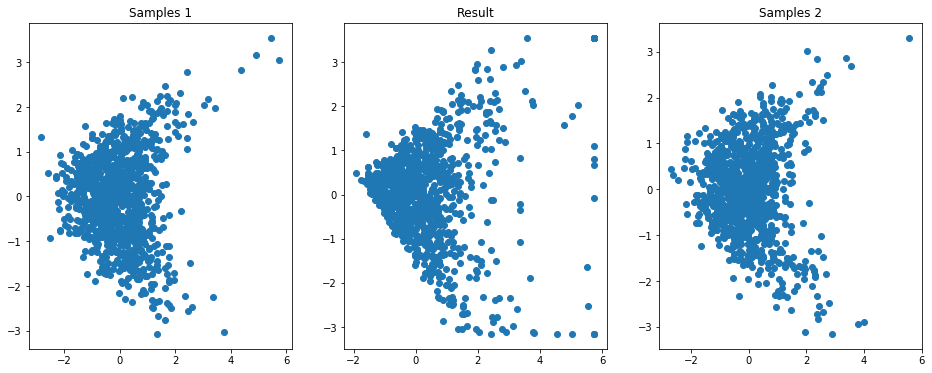

In [207]:
result = transform(*noisy_normals, use_PSA=False, use_one=True, inverse=True, 
                   use_third_cumulant=True, use_std=False, 
                   show_type="points", show=False, limits=False)

# OneLayer Model distribution on MNIST

In [208]:
architecture = getattr(models, "LinearOneLayer")

model = architecture.base(num_classes=10, **architecture.kwargs)

loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

criterion = F.cross_entropy
regularizer = None 


architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression
model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)
model3 = architecture.base(num_classes=10, **architecture.kwargs)
model4 = architecture.base(num_classes=10, **architecture.kwargs)

You are going to run models on the test set. Are you sure?


In [209]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve6/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining//curve8/checkpoint-30.pt')['model_state'])

In [228]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve5/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/Adam/curve6/checkpoint-30.pt')['model_state'])

In [229]:
def get_model(W, B, architecture):
    model_sampled = architecture.base(num_classes=10, **architecture.kwargs)
    model_samples = np.array(W) #.cpu().data.numpy()
    SIZE = model_sampled.middle_dim

    offset = 0
    for parameter in list(model_sampled.parameters())[:-1]:
        size = int(np.prod(parameter.size())/SIZE)
        value = model_samples[:, offset:offset+size]
        if size==10 or size==1:
             value = value.T
#         print(value.shape)
        value = value.reshape(parameter.size())
#         print(value.shape)
        parameter.data.copy_(torch.from_numpy(value))
        offset += size

    list(model_sampled.parameters())[-1].data.copy_(B.mean(0)) #torch.from_numpy(
    
    return model_sampled

def test(model):
    criterion = F.cross_entropy
    regularizer = None 
    train_res = utils.test(loaders['train'], model, criterion, regularizer)
    test_res = utils.test(loaders['test'], model, criterion, regularizer) 
    print(train_res)
    print(test_res)

def samples(model):
    p1 = list(model.parameters())[0].data.cpu().numpy()
    p2 = list(model.parameters())[1].data.cpu().numpy()
    p3 = list(model.parameters())[2].transpose(0,1).data.cpu().numpy()
    samples = np.hstack([p1, p2[:, None], p3])
    
    return samples

In [230]:
M1 = samples(model1)
M2 = samples(model2)

# Simple Arc

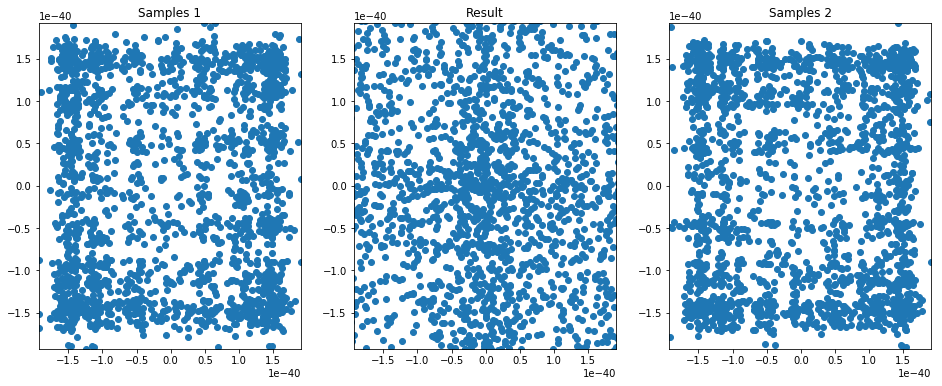

{'nll': 0.014958171818157038, 'loss': 0.014958171818157038, 'accuracy': 99.72333333333333}
{'nll': 0.0549722097158432, 'loss': 0.0549722097158432, 'accuracy': 98.21}


In [240]:
result = transform(M1, M2, use_PSA=False, use_one=False, inverse=False, 
                   use_third_cumulant=False, use_std=False, use_mean=False, 
                   show_type="points", K=795, show=False)

B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = torch.tensor(np.array(B))

model_inv = get_model(result, B, architecture)

test(model_inv)


# Arc with inverse

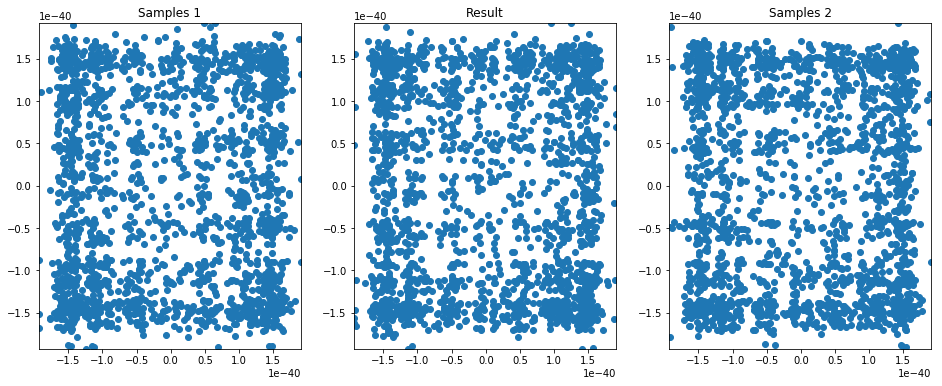

{'nll': 3.113937120691935, 'loss': 3.113937120691935, 'accuracy': 38.85166666666667}
{'nll': 3.108258728027344, 'loss': 3.108258728027344, 'accuracy': 38.24}


In [242]:
result = transform(M1, M2, use_PSA=False, use_one=False, inverse=True, 
                   use_third_cumulant=False, use_std=False, use_mean=False, 
                   show_type="points", K=80, show=False)

B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = torch.tensor(np.array(B))

model_inv = get_model(result, B, architecture)

test(model_inv)


# Simple Arc with third cumulant

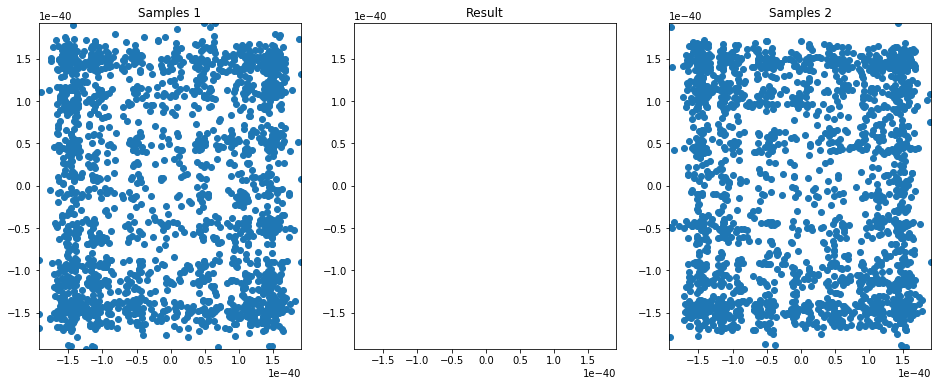

{'nll': 1507.9464073811848, 'loss': 1507.9464073811848, 'accuracy': 97.89}
{'nll': 3504.0278890625, 'loss': 3504.0278890625, 'accuracy': 96.73}


In [255]:
result = transform(M1, M2, use_PSA=True, use_one=True, inverse=False, 
                   use_third_cumulant=True, use_std=True, 
                   show_type="points", K=80, show=False)

B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = torch.tensor(np.array(B))

model_inv = get_model(result, B, architecture)

test(model_inv)


# Arc with inverse and third cumulant

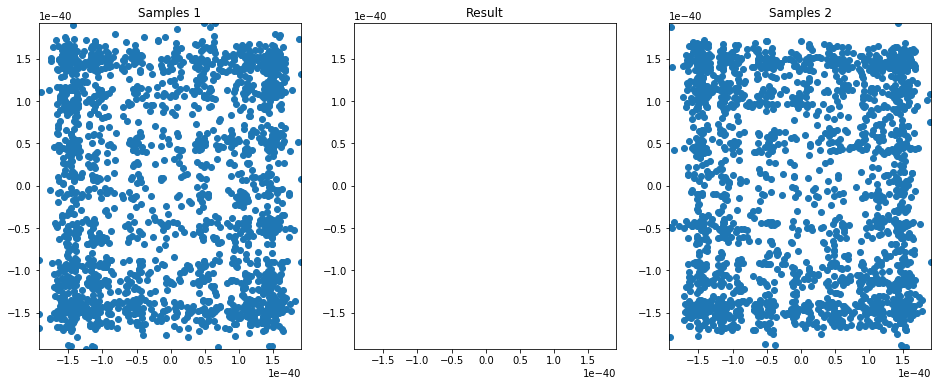

{'nll': 19.278686300659178, 'loss': 19.278686300659178, 'accuracy': 55.27166666666667}
{'nll': 19.883642906188964, 'loss': 19.883642906188964, 'accuracy': 55.43}


In [233]:
result = transform(M1, M2, use_PSA=True, use_one=True, inverse=True, 
                   use_third_cumulant=True, use_std=True, 
                   show_type="points", K=80, show=False)

B = []
B.append(list(model1.parameters())[-1].data.numpy())
B.append(list(model2.parameters())[-1].data.numpy())
B = torch.tensor(np.array(B))

model_inv = get_model(result, B, architecture)

test(model_inv)

In [234]:
test(model1)

{'nll': 0.013226513258616129, 'loss': 0.013226513258616129, 'accuracy': 99.80666666666667}
{'nll': 0.059089827513694765, 'loss': 0.059089827513694765, 'accuracy': 98.14}


In [235]:
test(model2)

{'nll': 0.01239673070733746, 'loss': 0.01239673070733746, 'accuracy': 99.82833333333333}
{'nll': 0.05553358361721039, 'loss': 0.05553358361721039, 'accuracy': 98.37}


# Flow

In [72]:
class BatchNorm(nn.Module):
    def __init__(self, dim_in):
        super(BatchNorm, self).__init__()

#         self.mu = torch.zeros(dim_in).cuda()
#         self.sig2 = torch.zeros(dim_in).cuda()+0.1
        
        self.mu = nn.Parameter(torch.zeros(dim_in), requires_grad=False)
        self.sig2 = nn.Parameter(torch.zeros(dim_in)+0.1, requires_grad=False)
        
        self.momentum=0.1
        
    def forward(self, x):

        if self.training:
            mu = x.mean(0)
            sig2 = (x-mu).pow(2).mean(0)  
            x = (x-mu)/(sig2 + 1.0e-6 ).sqrt()
            self.mu = nn.Parameter(self.momentum*mu + (1-self.momentum)*self.mu)
            self.sig2 =  nn.Parameter(self.momentum*sig2 + (1-self.momentum)*self.sig2)
            return x, sig2+1.0e-6 
        else: 
            x = (x-self.mu)/(self.sig2+1.0e-6).sqrt()
            return x, self.sig2+1.0e-6 
        
class SNet(nn.Module):
    def __init__(self, dim_in, dim_middle):
        super(SNet, self).__init__()
        affine = True
        self.h = nn.Tanh() #nn.LeakyReLU() #nn.Tanh()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_in)
        )
        
    def forward(self, x):   
        x = self.fc(x)
#         x = torch.clamp(x, -1, 1) 
        return x
    
class TNet(nn.Module):
    def __init__(self,  dim_in, dim_middle):
        super(TNet, self).__init__()
        affine = True
        self.h = nn.Tanh()
        self.fc = nn.Sequential(
            nn.Linear(dim_in, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_middle),
            self.h,
            nn.BatchNorm1d(dim_middle, affine=affine),
            nn.Linear(dim_middle, dim_in),
        )
        
    def forward(self, x):   
        x = self.fc(x)
        return x


In [73]:
import numpy as np
N_layers = 3
n_dim = 2
onezero = [0, 1]*n_dim
masks = torch.Tensor([[onezero[:n_dim], onezero[1:n_dim+1]]]*N_layers)
masks = masks.view(2*N_layers, -1)
len(masks)

6

In [74]:
class RealNVP(nn.Module):
    def __init__(self, mask, prior, in_dim, dim_middle):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.f_dim = in_dim
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([SNet(dim_in=self.f_dim, dim_middle=dim_middle) for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([TNet(dim_in=self.f_dim, dim_middle=dim_middle) for _ in range(len(mask))])
        self.b = torch.nn.ModuleList([BatchNorm(dim_in=self.f_dim) for _ in range(len(mask))])
        self.batch_norm = True
        self.verbose = False
        
        # for prediction
        self.relu = nn.ReLU()
        data_b2 = torch.FloatTensor(np.random.normal(size=(10, ))).cuda()
        self.b2 = nn.Parameter(data = data_b2, requires_grad=True)
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        for i, (s, t, b) in enumerate(zip(reversed(self.s), reversed(self.t), reversed(self.b))):
            m = self.mask[-i-1]
#             print('i', i, 'm', m)
            
            if self.verbose:
                print('z1', z)
            z = (m*z +(1-m)*(z-t(m*z))*(-s(m*z)).exp()).detach()
#             print('z1', z)
            if self.batch_norm:
                z = (z*(b.sig2+1.0e-6).sqrt()+b.mu).detach()
            if self.verbose:
                print('z2', z)
        
        x = z
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = 0
        for s, t, m, b in zip(self.s, self.t, self.mask, self.b):

            if self.batch_norm:
                z, sig2 = b(z)
#             print(m.shape, z.shape)
            s_res = s(m*z)
            z = m*z +(1-m)*(z*s_res.exp()+t(m*z))
           
            if self.batch_norm:
                log_det_J += ((1-m)*s_res-0.5*sig2.log()).sum(-1)
            else:
                log_det_J += ((1-m)*s_res).sum(-1)
        
        return z, log_det_J
    
    def log_prob(self,x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        
        logp = -0.5*np.log(np.pi*2)-0.5*z.pow(2)
        logp = logp.sum(-1)
#         logp = self.prior.log_prob(z)
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         shape = torch.Size((K, self.in_dim))
#         logp = torch.cuda.FloatTensor(x.shape[0])
#         self.prior.log_prob(z.cpu(), out=logp)
        
#         logp = self.prior.log_prob(z.cpu()).cuda()
#         print('logp', logp.shape)
        
        return logp+log_det_J
        
    def sample(self, K): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        shape = torch.Size((K, self.f_dim))
        e = torch.cuda.FloatTensor(shape)
        torch.randn(shape, out=e)   
        x = self.g(e)
        
#         z = self.prior.sample((K, )).cuda()
#         x = self.g(z)
        
        return x
    
    def forward(self, x, K=2000):
        
        x = x.view(x.size(0), -1)
        W = self.sample(K)
        W1 = W[:, :784]
        b1 = W[:, 784:785]
        W2 =  W[:, 785:].transpose(0,1)
        
        if self.verbose:
            print('x', x.shape)
            print('W1', W1.shape)
            print('b1', b1.shape)
            
        x = F.linear(x, W1, b1[:, 0])
        
        if self.verbose:
            print('x', x.shape)
            print(x.shape)
            
        x = self.relu(x)

        x = F.linear(x, W2, self.b2) 
#         x = 1/K*x
        
        if self.verbose:
            print(x.shape)
            
        return x
        

In [75]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
flow = RealNVP(masks, prior, 2, 100);
flow.cuda();

In [76]:
from torch.optim.lr_scheduler import StepLR

def train(flow, epochs=20, lr=1e-5, batchsize=512, step=10,  start_epoch=1):
    flow.cuda();
    flow.train();
    trainable_parametrs = filter(lambda param: param.requires_grad, flow.parameters()) # list of all trainable parameters in a flow
    optimizer = torch.optim.Adam(trainable_parametrs, lr=lr, weight_decay=1e-4)# choose an optimizer, use module torch.optim
    scheduler = StepLR(optimizer, step_size=20, gamma=0.9)# decrease learning rate by torch.optim.lr_scheduler
    
    
    for epoch in range(start_epoch, epochs+1):  
        scheduler.step()
        flow.train()
        
        t = time.time()
        total_loss = 0

        it = 100
        for _ in range(it):
        
            X = datasets.make_moons(n_samples=batchsize, noise=.05)[0] 
            X = torch.FloatTensor(X).cuda()
            loss = -flow.log_prob(X).mean() #  compute the maximum-likelihood loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss+=loss
        
        total_loss /= it
        if epoch % step == 0:
            print('epoch %s:' % epoch, 'loss = %.3f' % total_loss, 'time = %.2f' %  (time.time()-t))
            transform(*noisy_moons, use_PSA=False, use_one=True, show=False, use_std=False, inverse=False, 
             use_third_cumulant=False, t=0.5, show_type='points', K=2, use_flow=True)
            flow.cuda()
            
    

epoch 5: loss = 0.857 time = 3.28
Parameter containing:
tensor([ 7.6246e-02, -4.7366e-10], requires_grad=True)


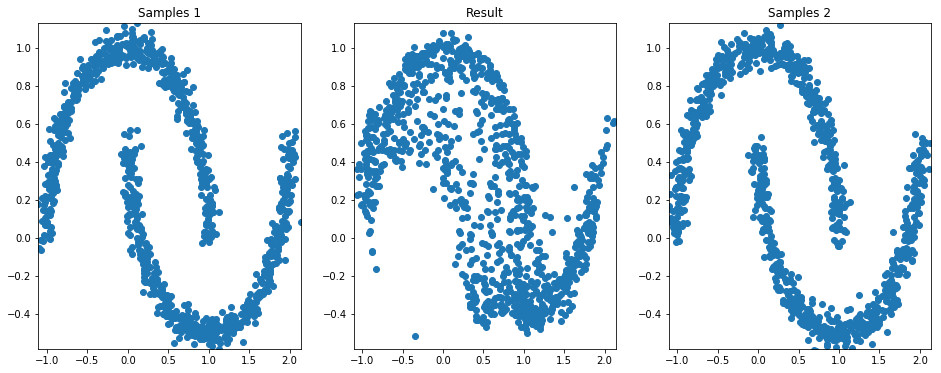

epoch 10: loss = 0.764 time = 3.14
Parameter containing:
tensor([-5.4031e-02,  1.7516e-08], requires_grad=True)


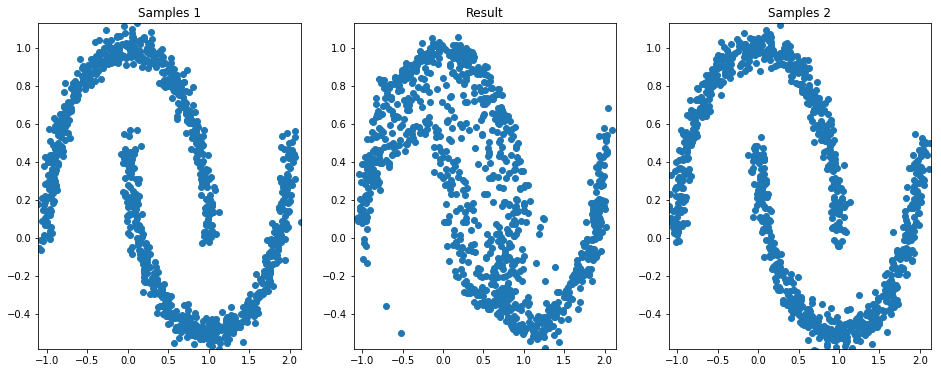

epoch 15: loss = 0.667 time = 3.05
Parameter containing:
tensor([-9.3696e-02,  3.2067e-08], requires_grad=True)


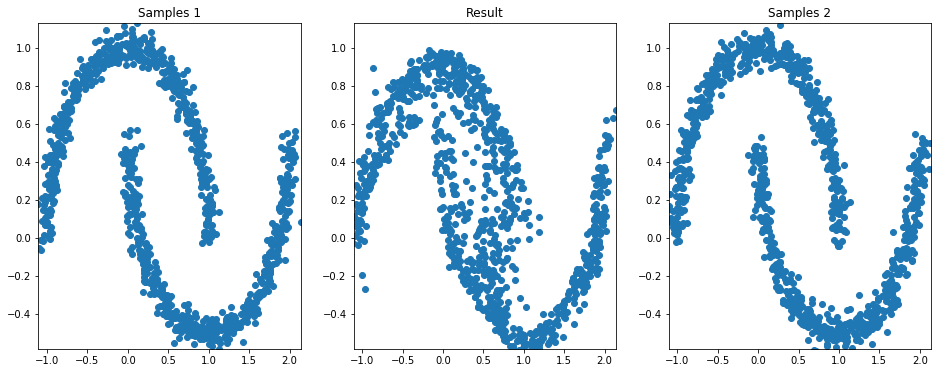

epoch 20: loss = 0.614 time = 3.26
Parameter containing:
tensor([-1.0195e-01,  4.8510e-08], requires_grad=True)


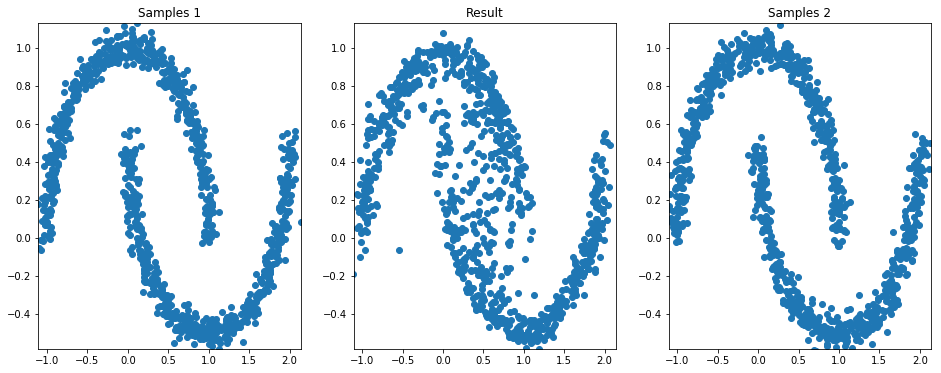

epoch 25: loss = 0.550 time = 3.14
Parameter containing:
tensor([-7.8356e-02,  3.8464e-08], requires_grad=True)


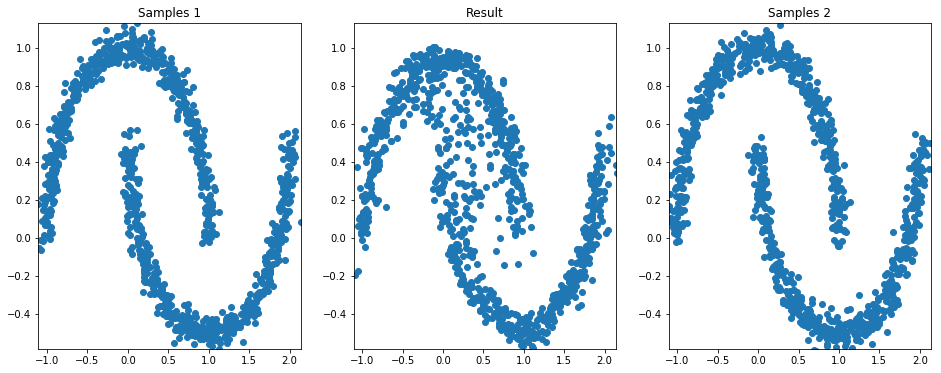

epoch 30: loss = 0.487 time = 3.17
Parameter containing:
tensor([-7.3047e-02,  2.8697e-08], requires_grad=True)


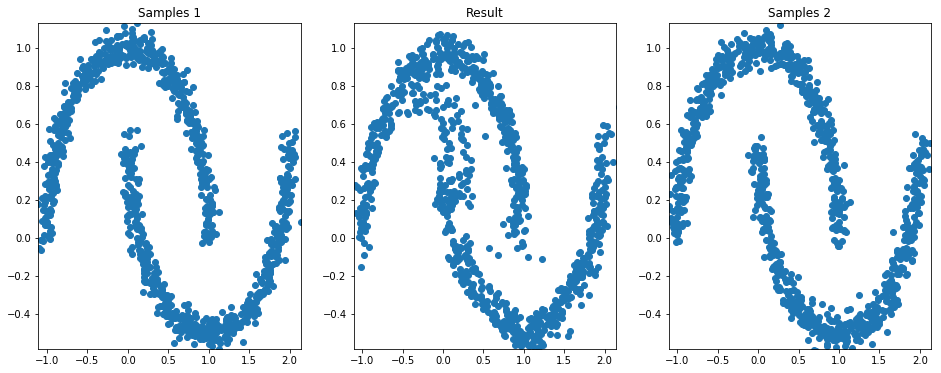

epoch 35: loss = 0.445 time = 3.19
Parameter containing:
tensor([-4.6015e-02,  3.0535e-08], requires_grad=True)


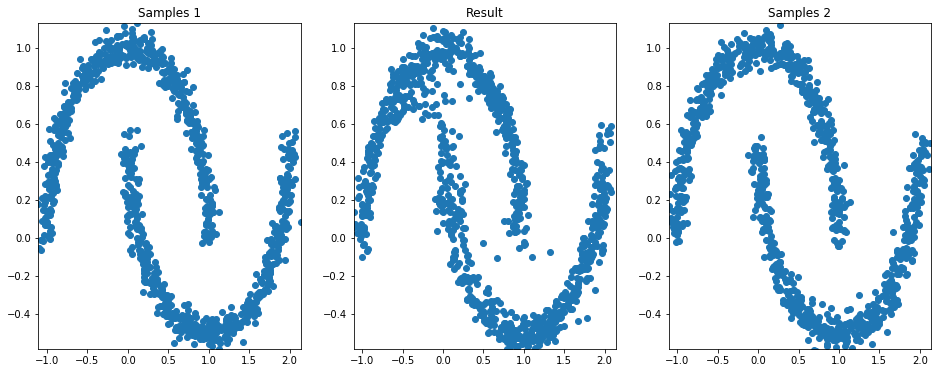

epoch 40: loss = 0.434 time = 3.22
Parameter containing:
tensor([-2.5477e-02,  1.1561e-08], requires_grad=True)


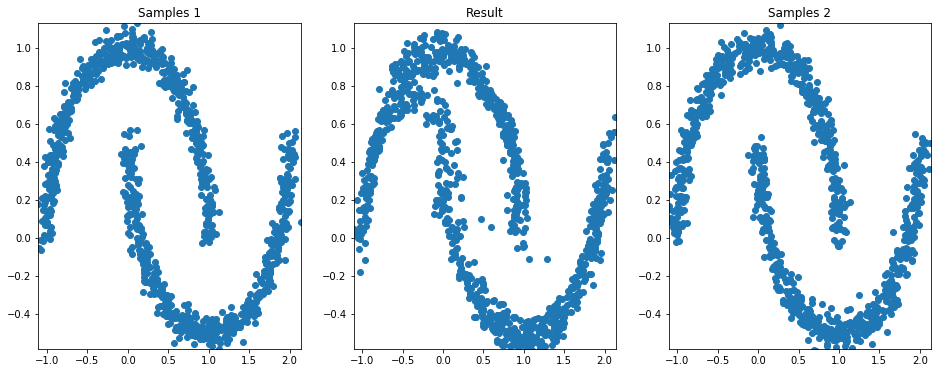

epoch 45: loss = 0.420 time = 3.16
Parameter containing:
tensor([-1.7906e-02,  1.2554e-08], requires_grad=True)


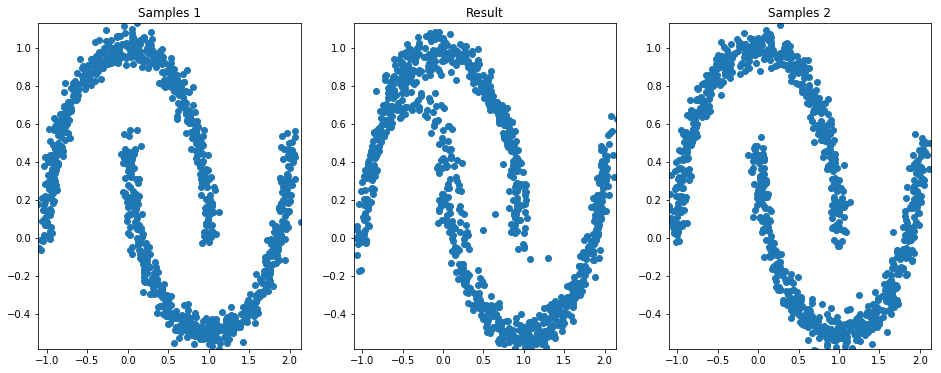

epoch 50: loss = 0.421 time = 3.10
Parameter containing:
tensor([-8.4783e-03,  2.4838e-08], requires_grad=True)


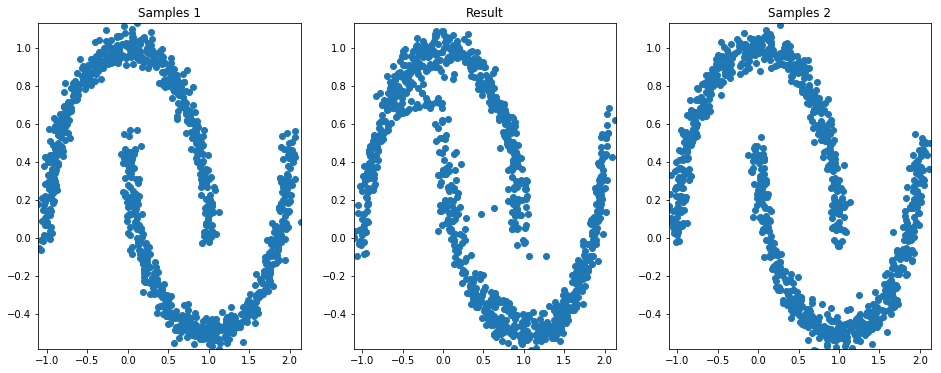

epoch 55: loss = 0.404 time = 3.23
Parameter containing:
tensor([-1.6256e-03,  1.6729e-08], requires_grad=True)


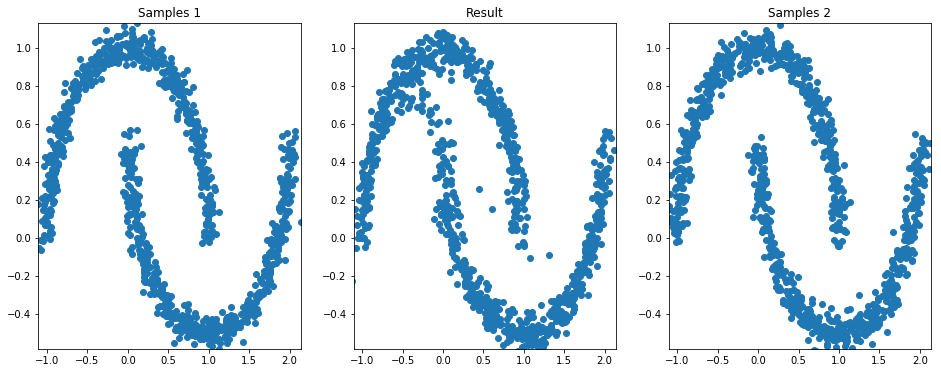

epoch 60: loss = 0.400 time = 3.37
Parameter containing:
tensor([3.3848e-03, 2.2447e-08], requires_grad=True)


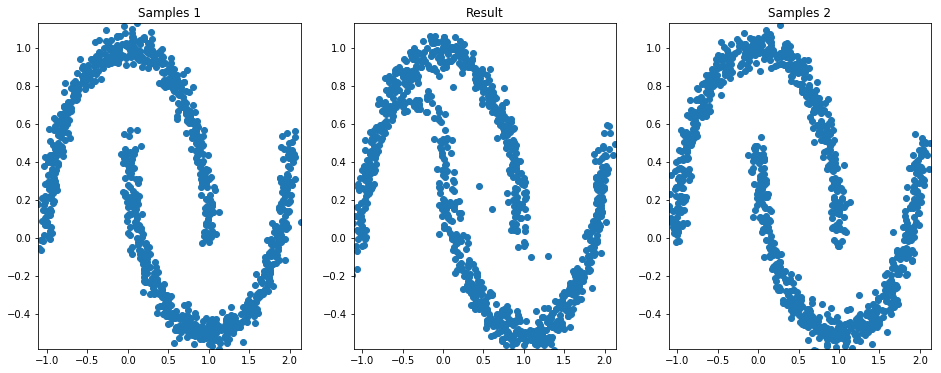

epoch 65: loss = 0.393 time = 3.23
Parameter containing:
tensor([1.0399e-02, 1.7853e-08], requires_grad=True)


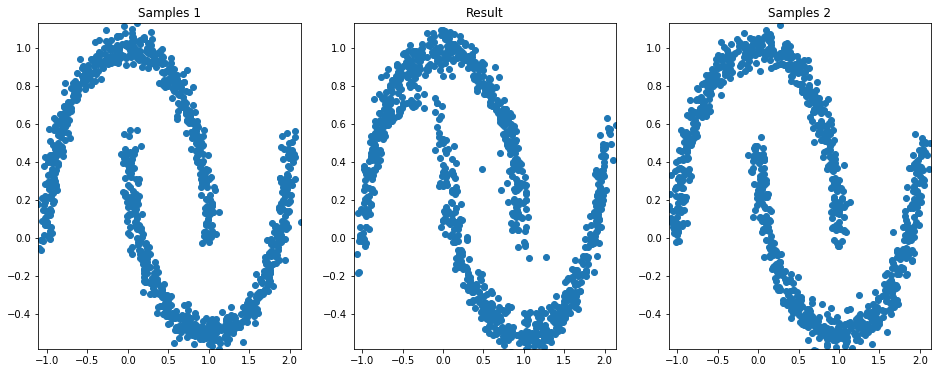

epoch 70: loss = 0.395 time = 3.30
Parameter containing:
tensor([9.9122e-03, 1.9990e-08], requires_grad=True)


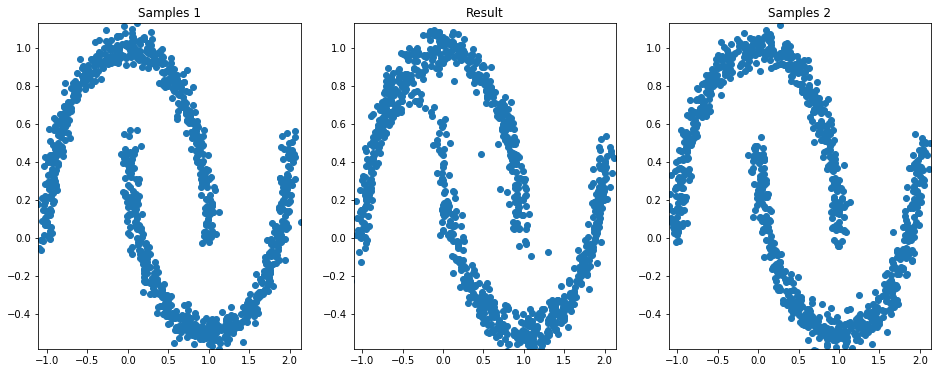

epoch 75: loss = 0.386 time = 3.37
Parameter containing:
tensor([1.6079e-02, 1.2926e-08], requires_grad=True)


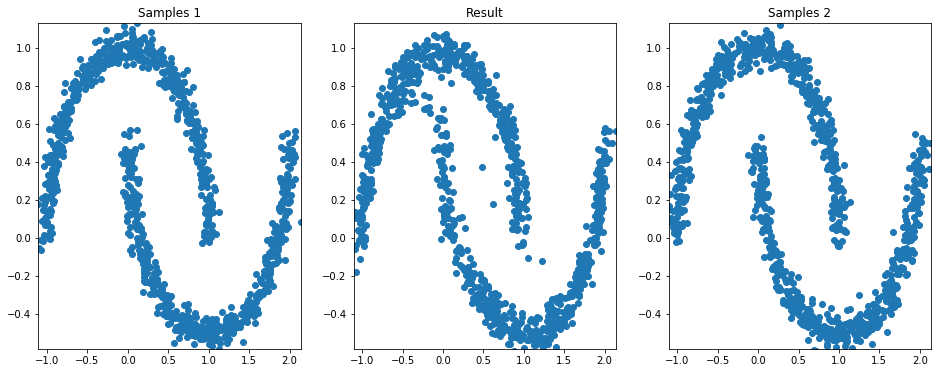

epoch 80: loss = 0.385 time = 3.31
Parameter containing:
tensor([2.0824e-02, 1.2423e-08], requires_grad=True)


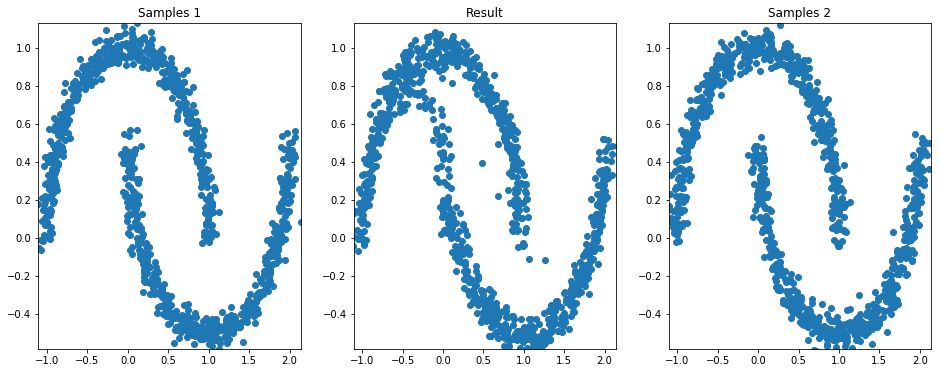

epoch 85: loss = 0.382 time = 3.35
Parameter containing:
tensor([1.9332e-02, 1.5465e-08], requires_grad=True)


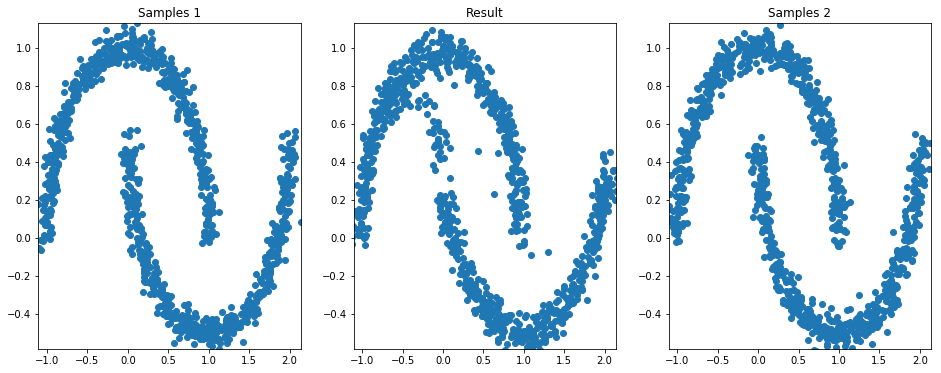

epoch 90: loss = 0.388 time = 3.30
Parameter containing:
tensor([2.0380e-02, 1.2871e-08], requires_grad=True)


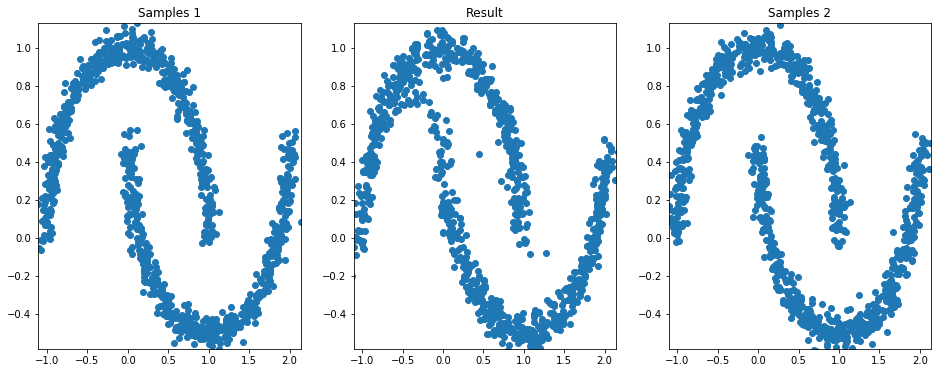

epoch 95: loss = 0.379 time = 3.30
Parameter containing:
tensor([2.5911e-02, 1.5054e-08], requires_grad=True)


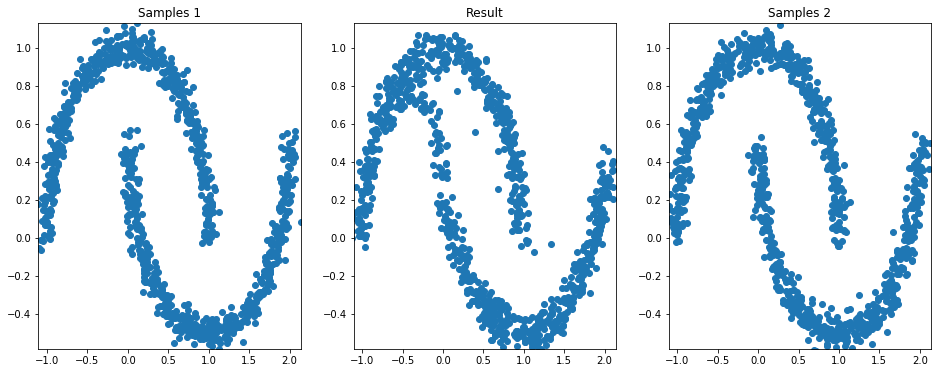

epoch 100: loss = 0.379 time = 3.14
Parameter containing:
tensor([2.7398e-02, 1.3377e-08], requires_grad=True)


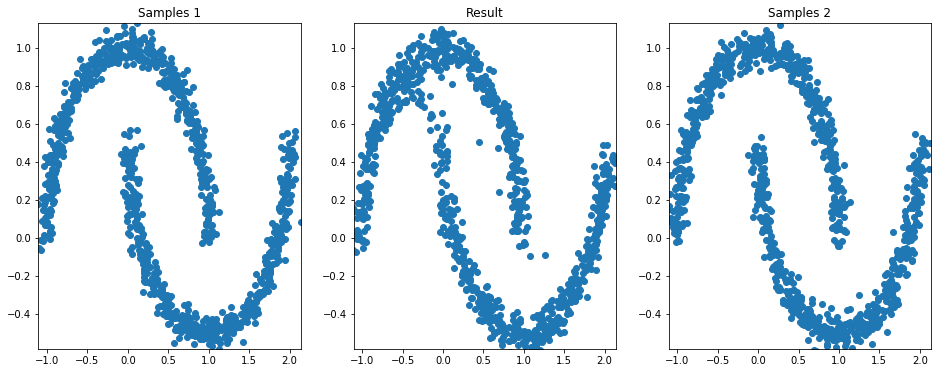

epoch 105: loss = 0.380 time = 3.42
Parameter containing:
tensor([2.4435e-02, 1.6386e-08], requires_grad=True)


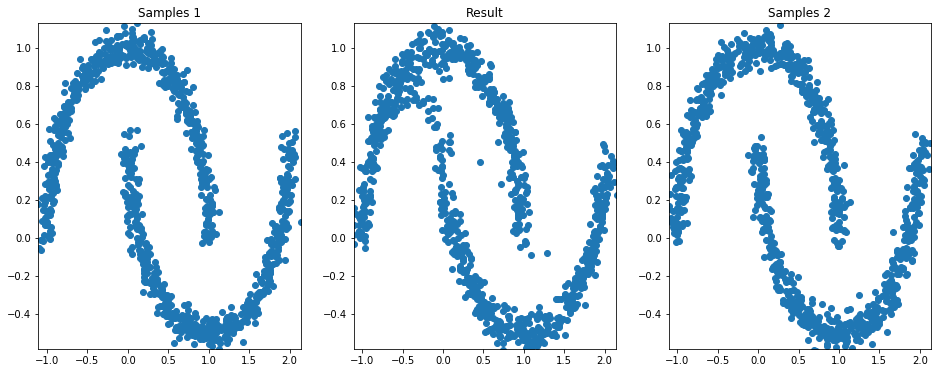

epoch 110: loss = 0.370 time = 3.31
Parameter containing:
tensor([3.1167e-02, 9.4167e-09], requires_grad=True)


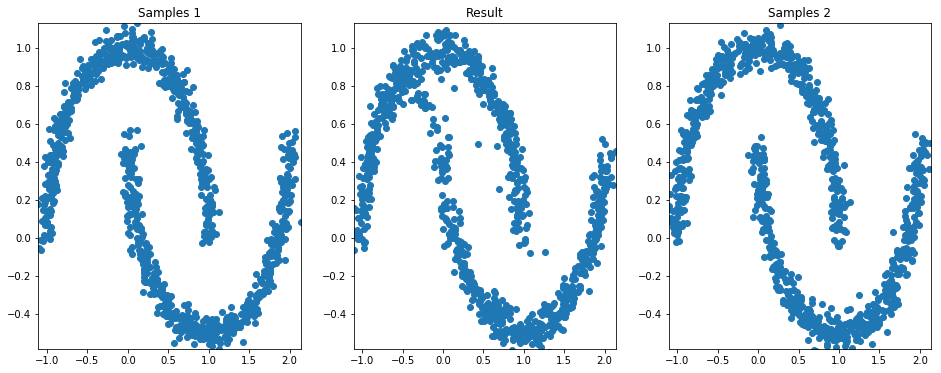

epoch 115: loss = 0.373 time = 3.42
Parameter containing:
tensor([2.7451e-02, 8.5620e-09], requires_grad=True)


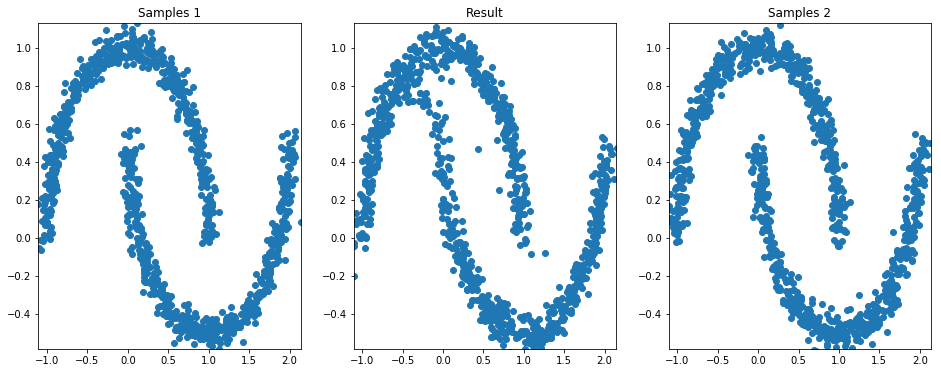

epoch 120: loss = 0.377 time = 3.34
Parameter containing:
tensor([2.9799e-02, 1.9708e-08], requires_grad=True)


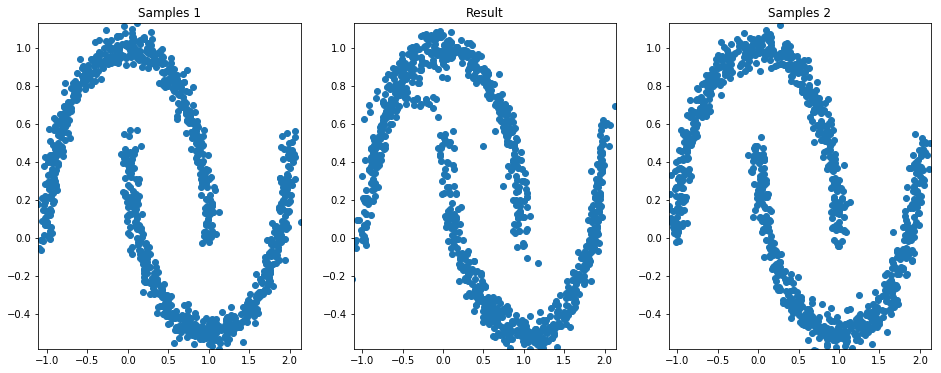

epoch 125: loss = 0.375 time = 3.36
Parameter containing:
tensor([3.0740e-02, 1.2846e-08], requires_grad=True)


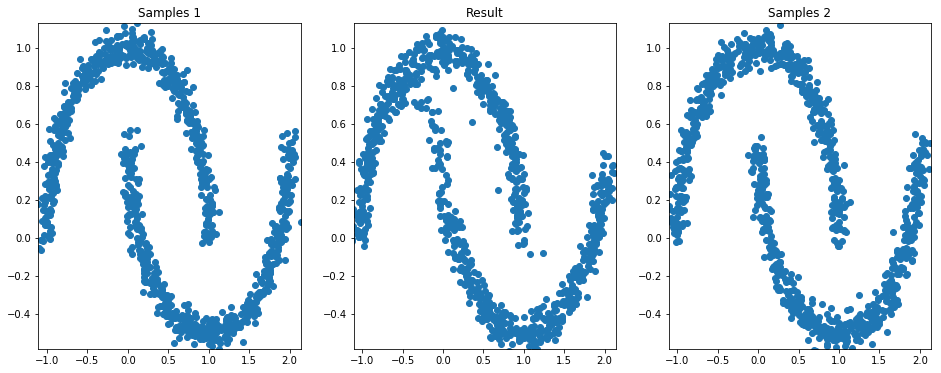

epoch 130: loss = 0.366 time = 3.34
Parameter containing:
tensor([3.2593e-02, 9.9731e-09], requires_grad=True)


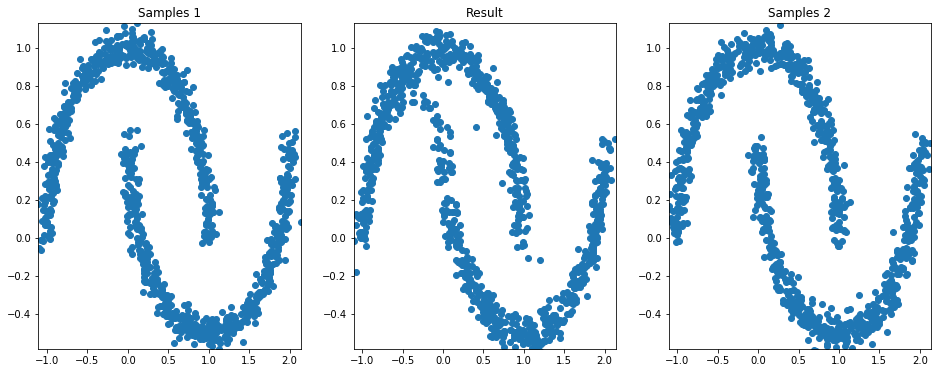

epoch 135: loss = 0.374 time = 3.27
Parameter containing:
tensor([3.4060e-02, 1.1892e-08], requires_grad=True)


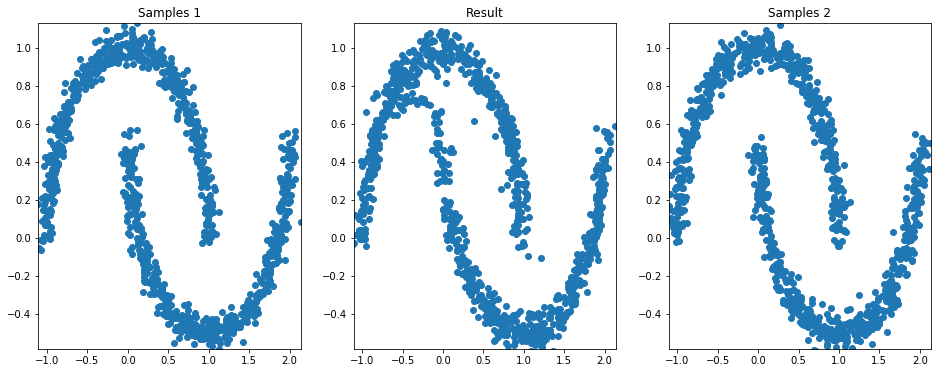

epoch 140: loss = 0.371 time = 3.37
Parameter containing:
tensor([3.2159e-02, 1.4718e-08], requires_grad=True)


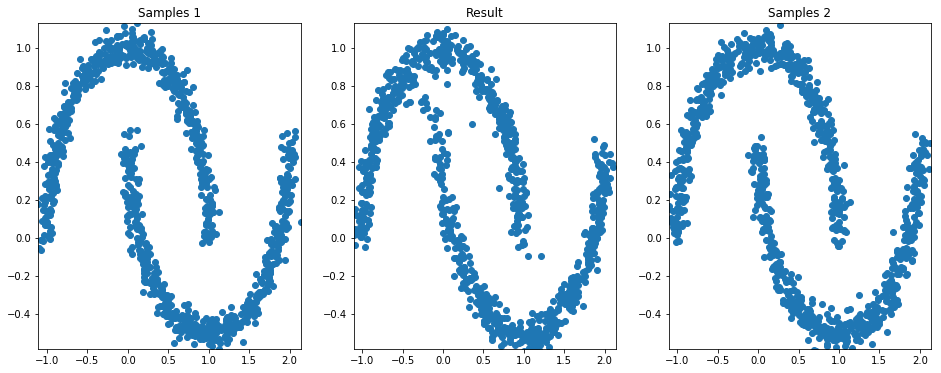

epoch 145: loss = 0.367 time = 3.15
Parameter containing:
tensor([3.5251e-02, 1.3547e-08], requires_grad=True)


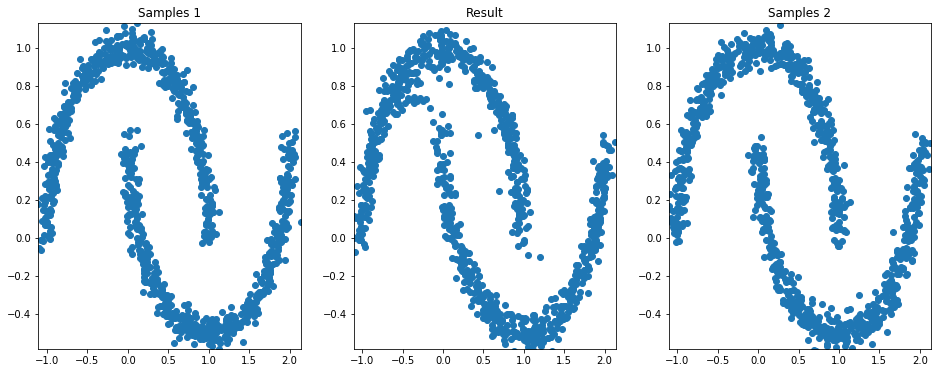

epoch 150: loss = 0.367 time = 3.14
Parameter containing:
tensor([3.6308e-02, 6.0517e-09], requires_grad=True)


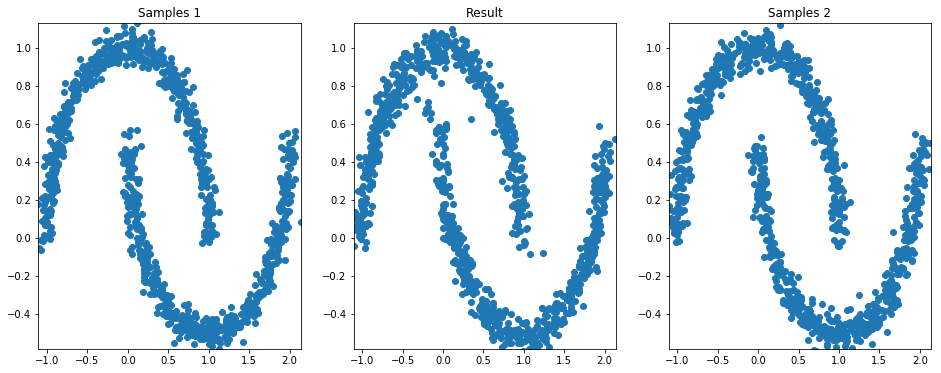

epoch 155: loss = 0.365 time = 3.20
Parameter containing:
tensor([3.5167e-02, 5.8653e-09], requires_grad=True)


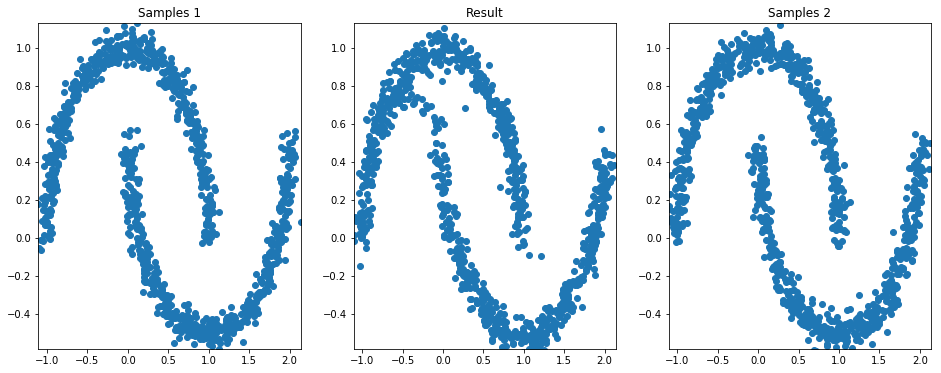

epoch 160: loss = 0.363 time = 3.18
Parameter containing:
tensor([3.7644e-02, 1.4027e-08], requires_grad=True)


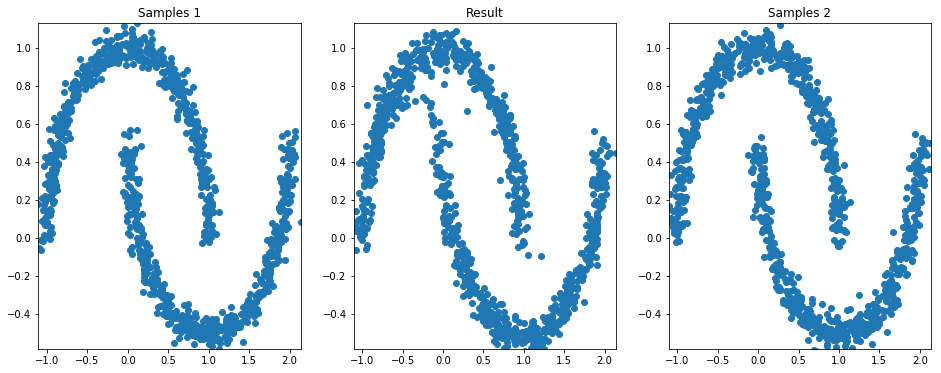

epoch 165: loss = 0.361 time = 3.20
Parameter containing:
tensor([3.7062e-02, 9.2340e-09], requires_grad=True)


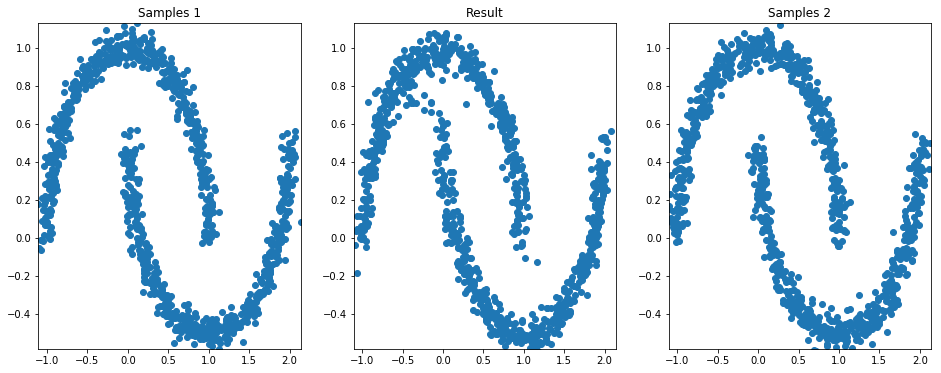

epoch 170: loss = 0.361 time = 3.22
Parameter containing:
tensor([3.7105e-02, 7.4074e-09], requires_grad=True)


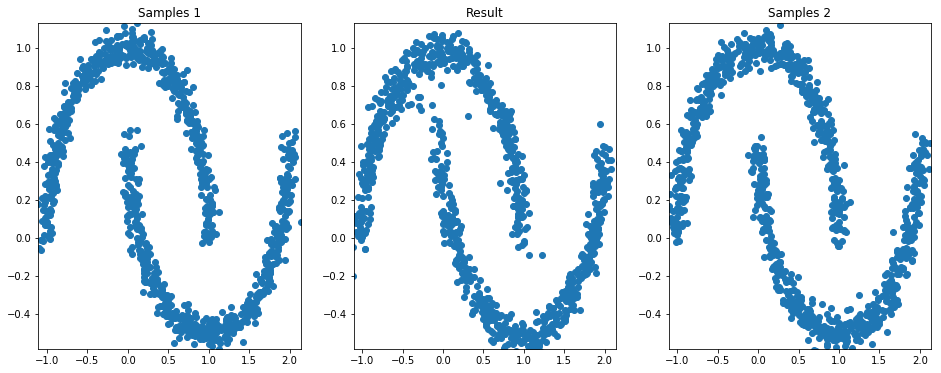

epoch 175: loss = 0.363 time = 3.24
Parameter containing:
tensor([4.0165e-02, 9.6609e-09], requires_grad=True)


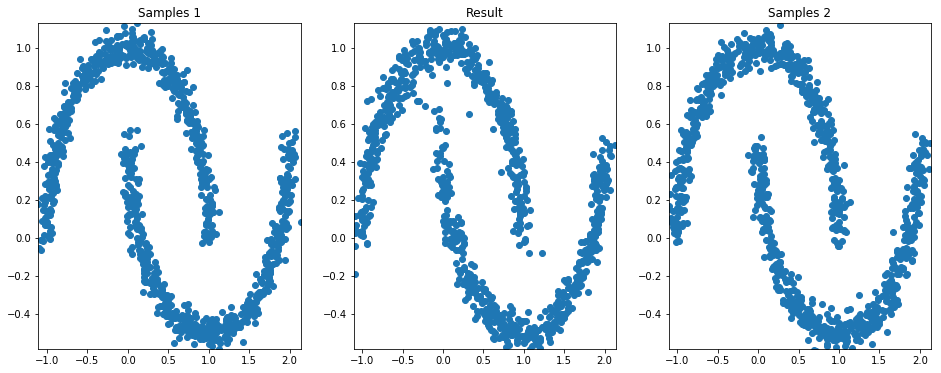

epoch 180: loss = 0.360 time = 3.15
Parameter containing:
tensor([4.0438e-02, 9.6019e-09], requires_grad=True)


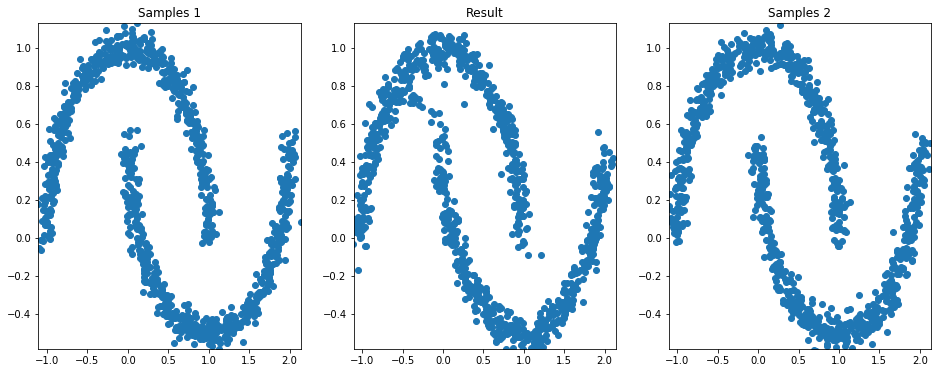

epoch 185: loss = 0.364 time = 3.41
Parameter containing:
tensor([4.1863e-02, 7.1878e-09], requires_grad=True)


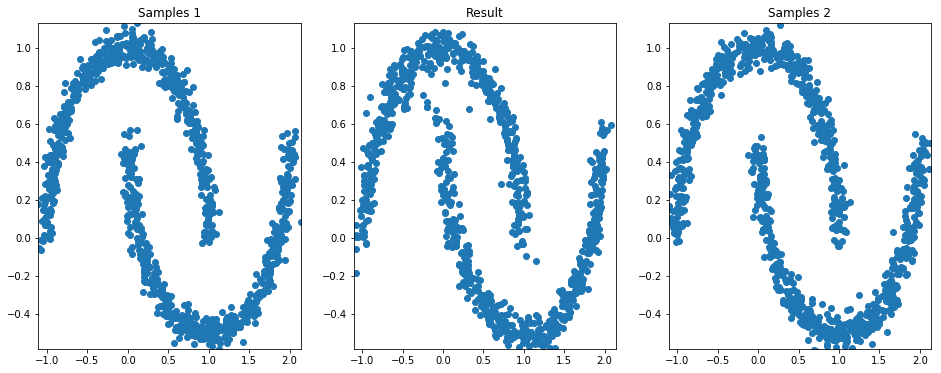

epoch 190: loss = 0.361 time = 3.31
Parameter containing:
tensor([4.3793e-02, 1.0434e-09], requires_grad=True)


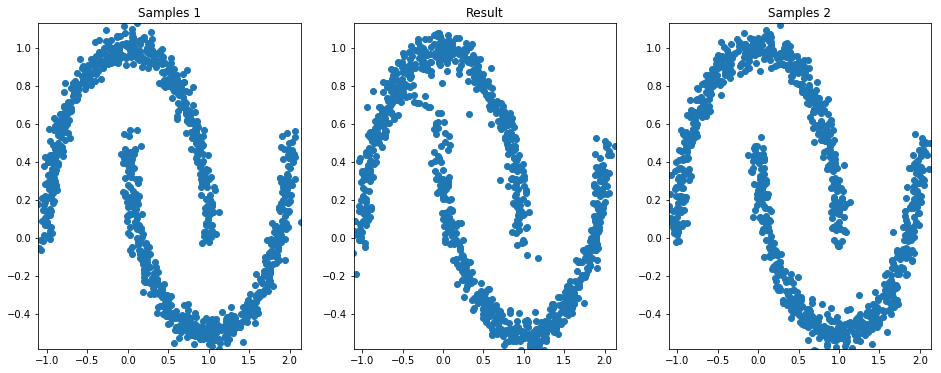

epoch 195: loss = 0.356 time = 3.41
Parameter containing:
tensor([4.2684e-02, 1.3531e-08], requires_grad=True)


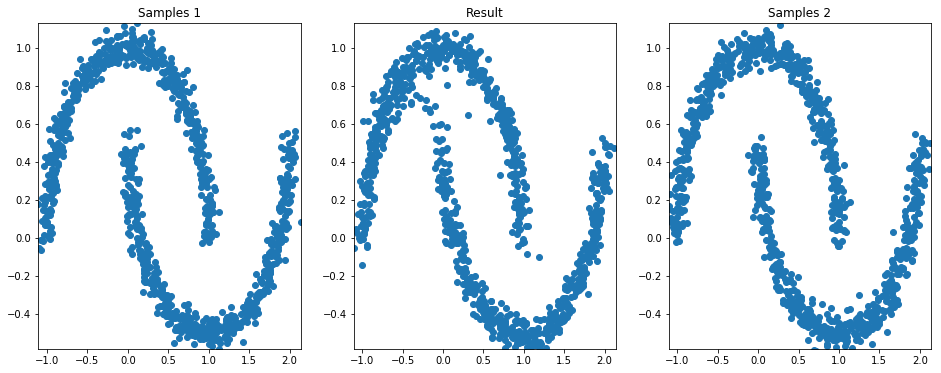

epoch 200: loss = 0.355 time = 3.40
Parameter containing:
tensor([4.7095e-02, 1.0519e-08], requires_grad=True)


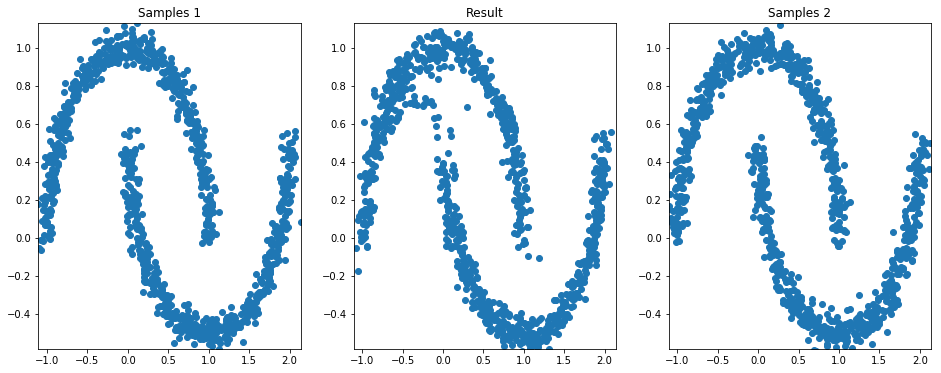

epoch 205: loss = 0.359 time = 3.45
Parameter containing:
tensor([4.7447e-02, 1.2509e-08], requires_grad=True)


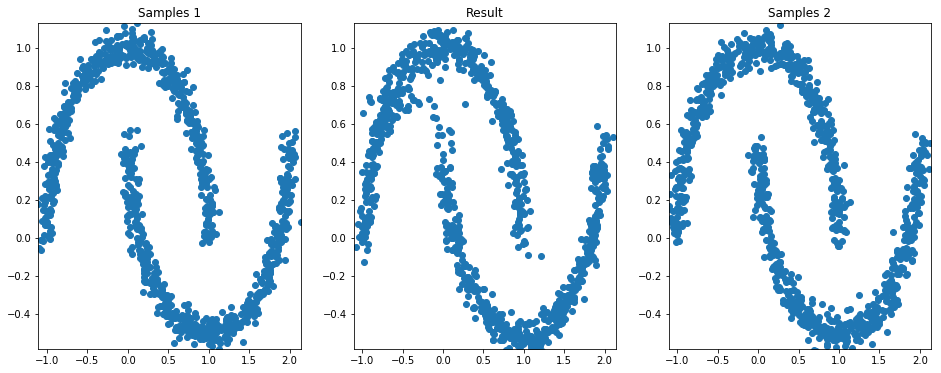

epoch 210: loss = 0.354 time = 3.21
Parameter containing:
tensor([4.8547e-02, 9.5135e-09], requires_grad=True)


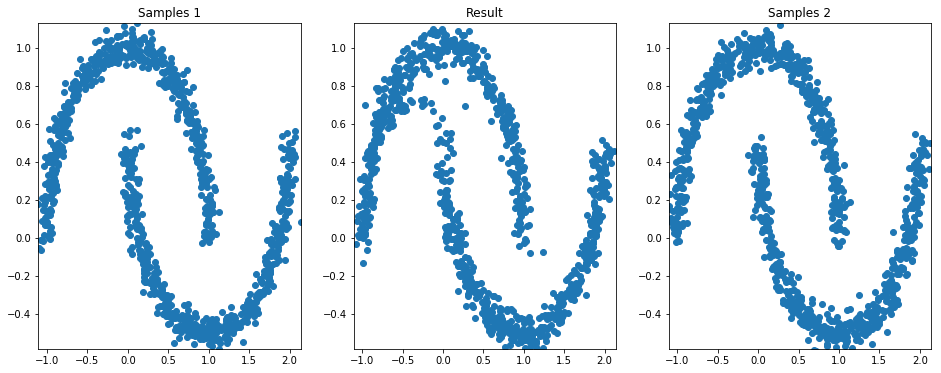

epoch 215: loss = 0.351 time = 3.36
Parameter containing:
tensor([4.8660e-02, 4.3730e-09], requires_grad=True)


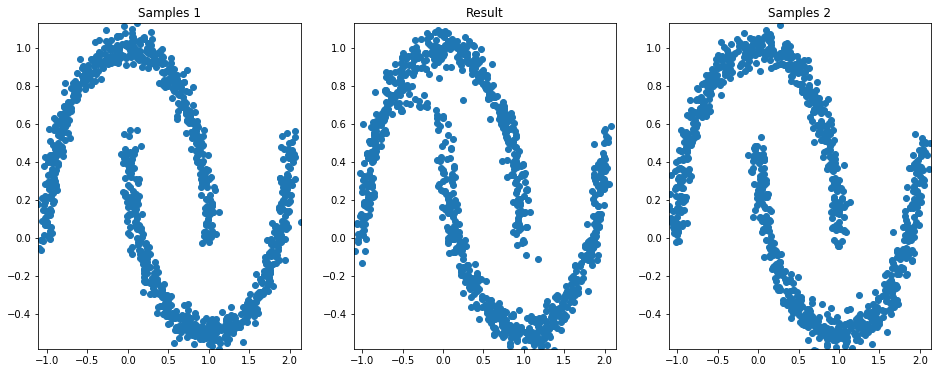

epoch 220: loss = 0.353 time = 3.28
Parameter containing:
tensor([5.0898e-02, 1.0279e-08], requires_grad=True)


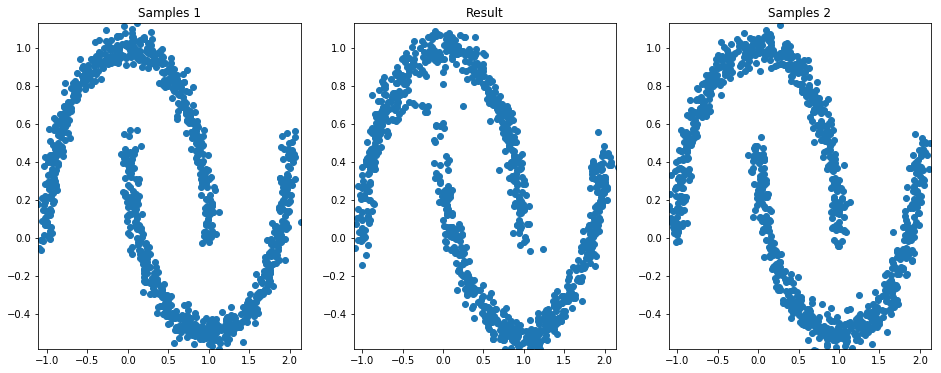

epoch 225: loss = 0.349 time = 3.34
Parameter containing:
tensor([5.0826e-02, 9.5871e-09], requires_grad=True)


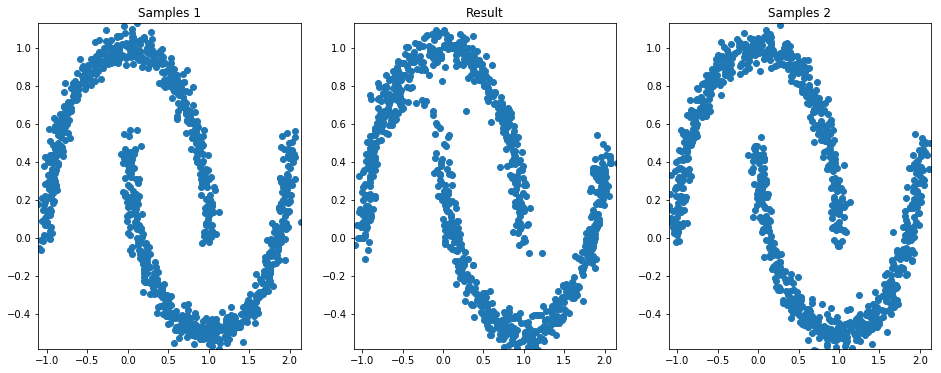

epoch 230: loss = 0.349 time = 3.34
Parameter containing:
tensor([5.2772e-02, 4.4135e-09], requires_grad=True)


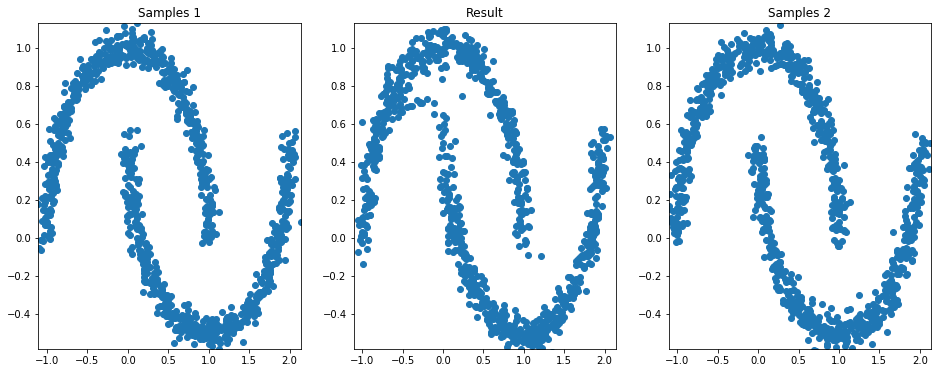

epoch 235: loss = 0.353 time = 3.25
Parameter containing:
tensor([4.9989e-02, 7.3620e-09], requires_grad=True)


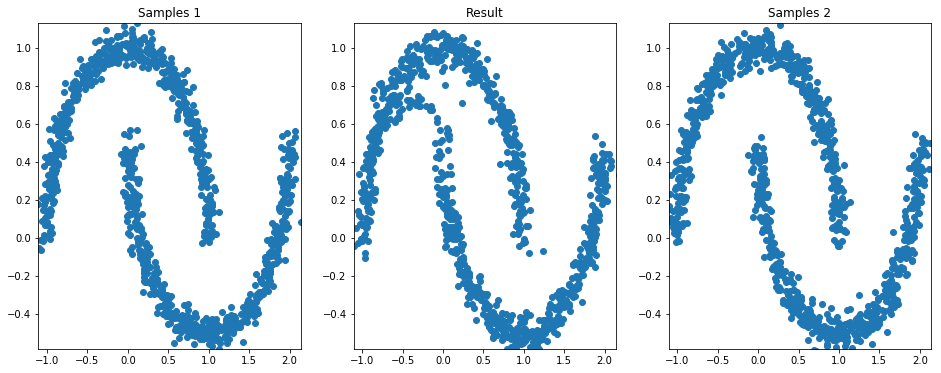

epoch 240: loss = 0.353 time = 3.39
Parameter containing:
tensor([5.2810e-02, 3.3558e-09], requires_grad=True)


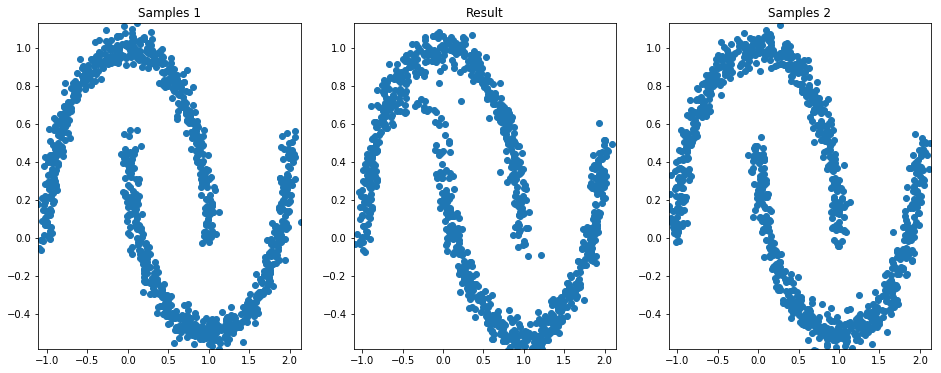

epoch 245: loss = 0.348 time = 3.27
Parameter containing:
tensor([5.4459e-02, 3.0566e-09], requires_grad=True)


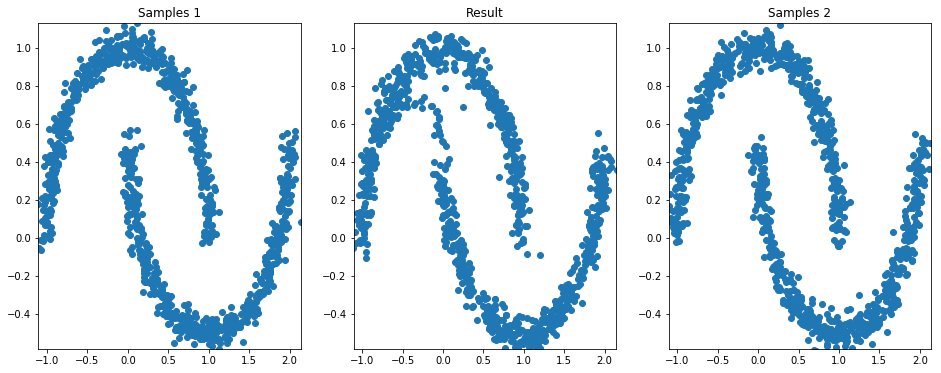

epoch 250: loss = 0.346 time = 3.28
Parameter containing:
tensor([5.1327e-02, 4.4341e-09], requires_grad=True)


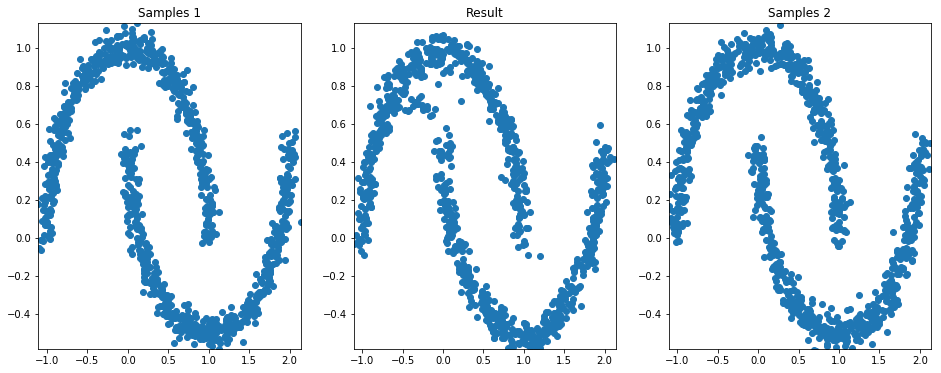

epoch 255: loss = 0.349 time = 3.28
Parameter containing:
tensor([5.3218e-02, 4.3647e-09], requires_grad=True)


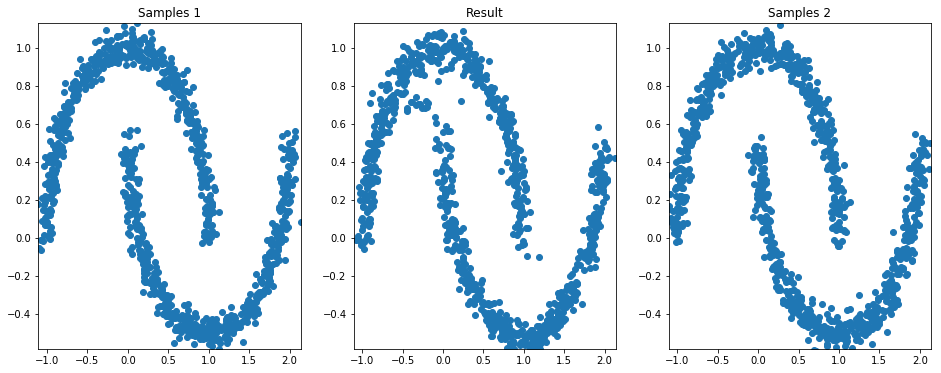

epoch 260: loss = 0.348 time = 3.32
Parameter containing:
tensor([5.4334e-02, 1.0925e-08], requires_grad=True)


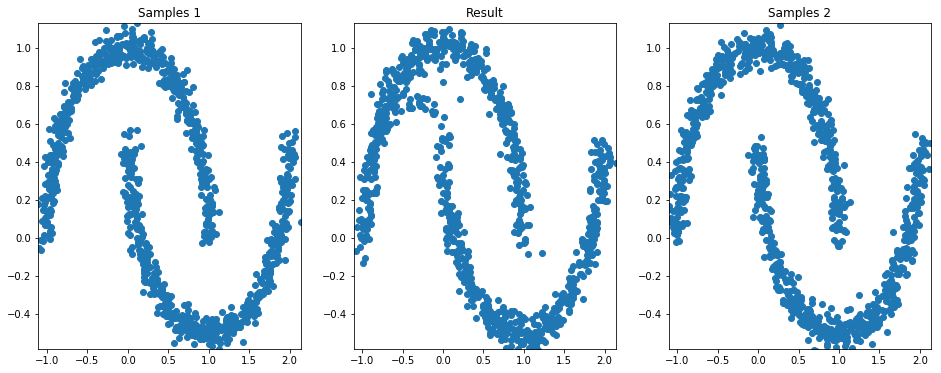

epoch 265: loss = 0.347 time = 3.19
Parameter containing:
tensor([5.3637e-02, 7.8263e-09], requires_grad=True)


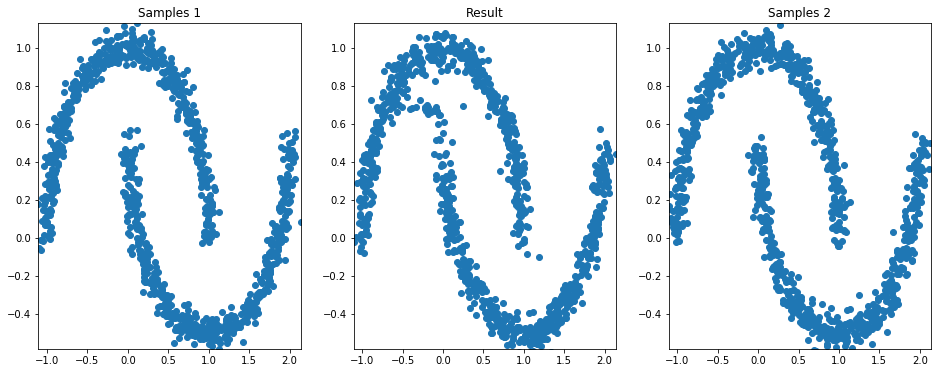

epoch 270: loss = 0.350 time = 3.37
Parameter containing:
tensor([5.6755e-02, 8.0821e-09], requires_grad=True)


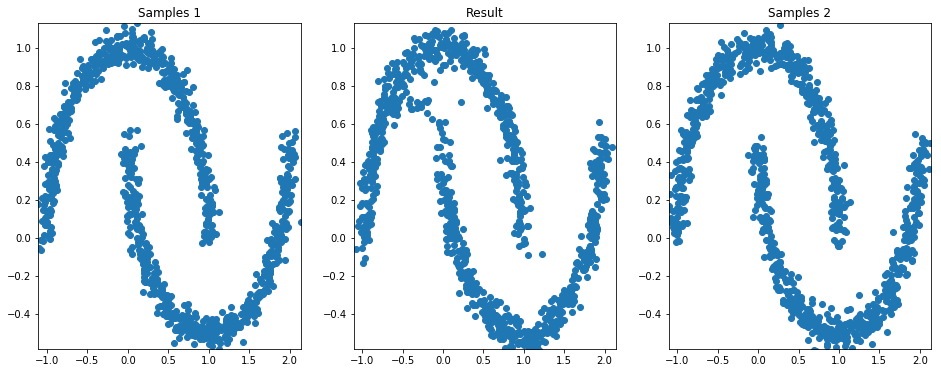

epoch 275: loss = 0.352 time = 3.36
Parameter containing:
tensor([5.8546e-02, 8.7929e-09], requires_grad=True)


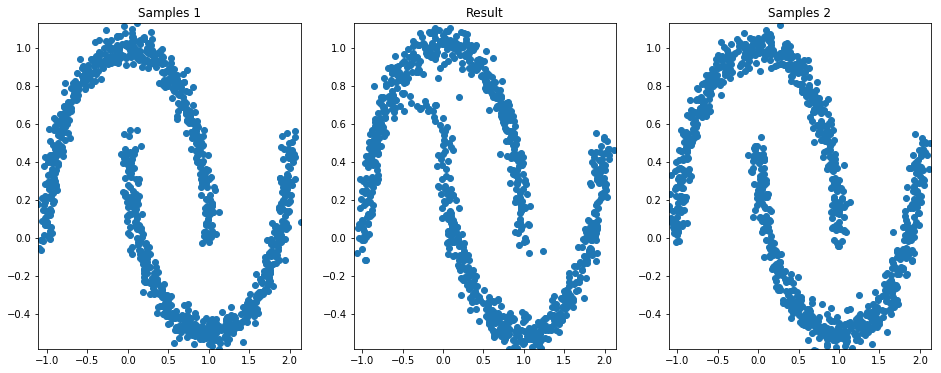

epoch 280: loss = 0.348 time = 3.30
Parameter containing:
tensor([5.8453e-02, 3.6137e-09], requires_grad=True)


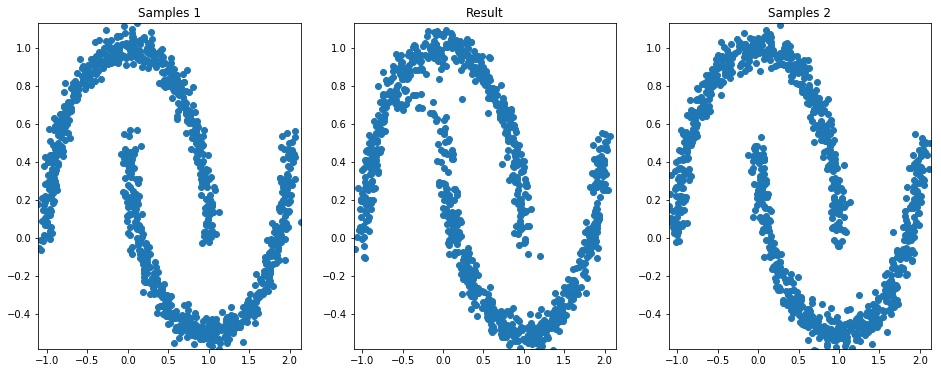

epoch 285: loss = 0.343 time = 3.26
Parameter containing:
tensor([5.7332e-02, 3.4851e-09], requires_grad=True)


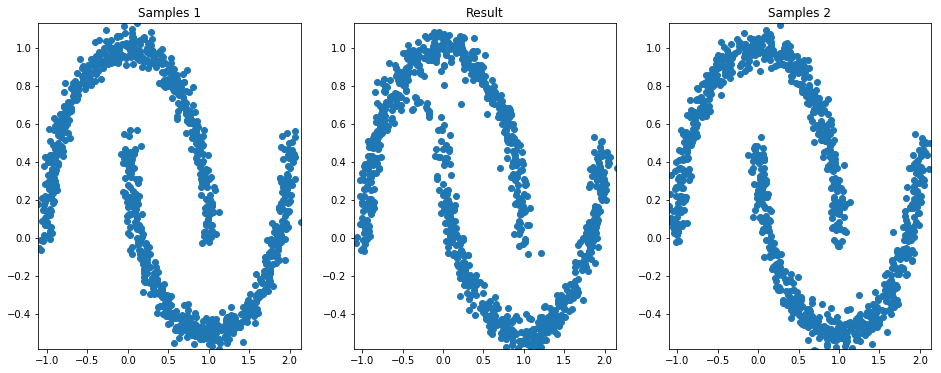

epoch 290: loss = 0.345 time = 3.30
Parameter containing:
tensor([5.7415e-02, 6.5279e-09], requires_grad=True)


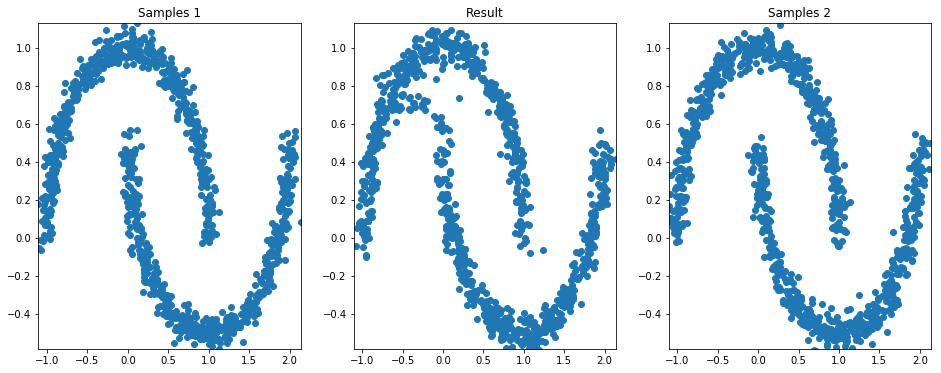

epoch 295: loss = 0.344 time = 3.24
Parameter containing:
tensor([5.7972e-02, 9.2553e-09], requires_grad=True)


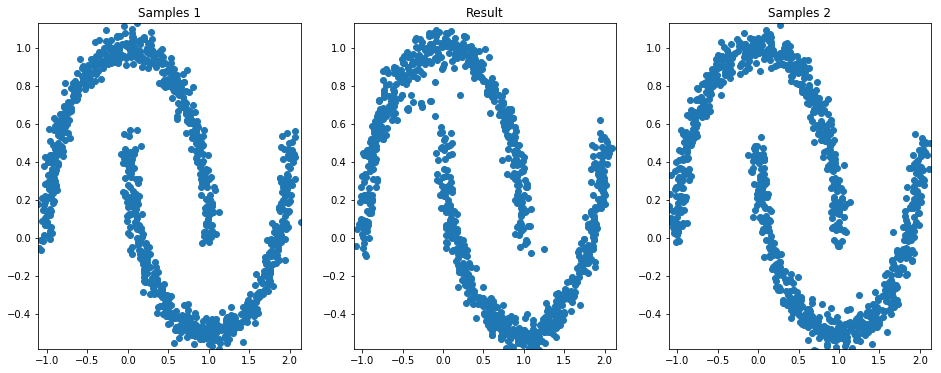

epoch 300: loss = 0.343 time = 3.39
Parameter containing:
tensor([5.7269e-02, 7.1794e-09], requires_grad=True)


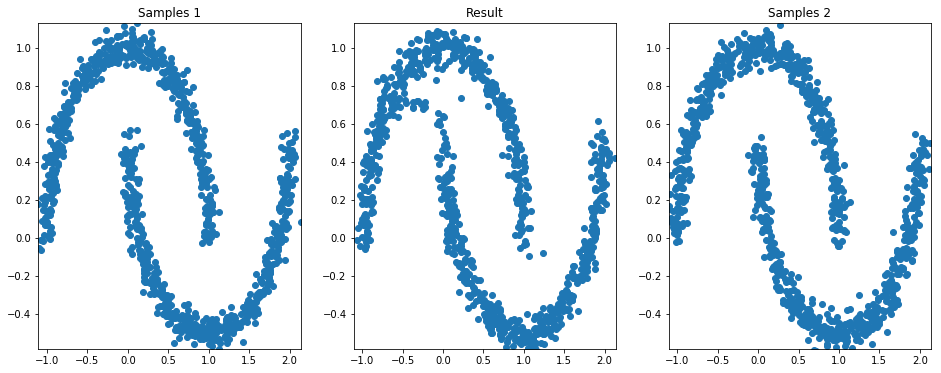

epoch 305: loss = 0.346 time = 3.37
Parameter containing:
tensor([6.3957e-02, 6.4658e-09], requires_grad=True)


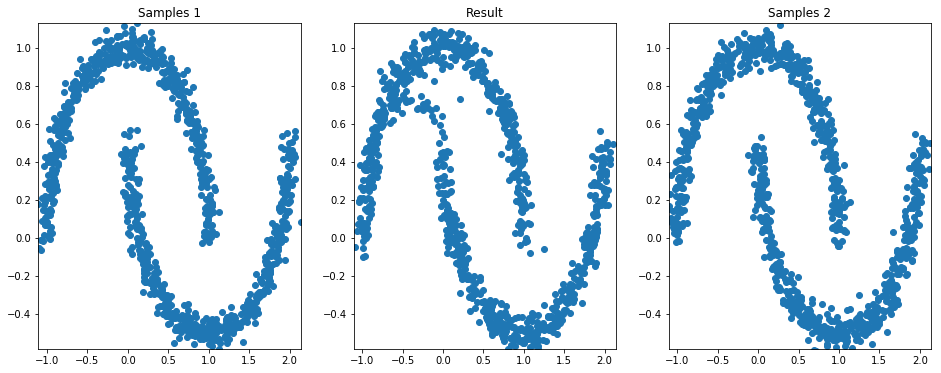

epoch 310: loss = 0.343 time = 3.36
Parameter containing:
tensor([5.9002e-02, 5.8000e-09], requires_grad=True)


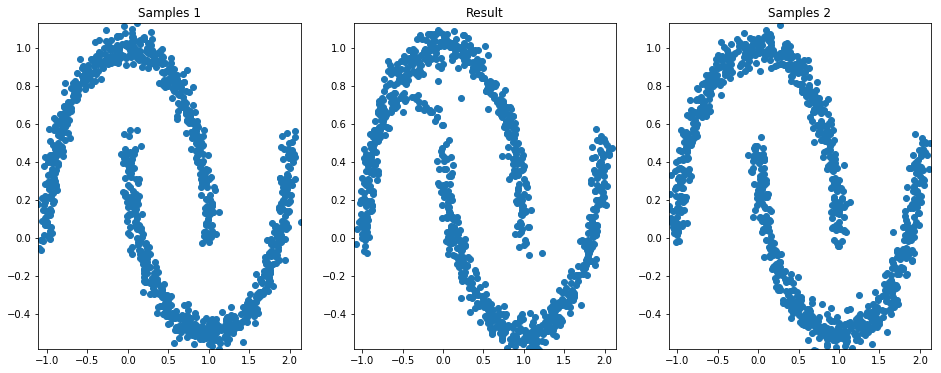

epoch 315: loss = 0.341 time = 3.31
Parameter containing:
tensor([5.7110e-02, 8.5137e-09], requires_grad=True)


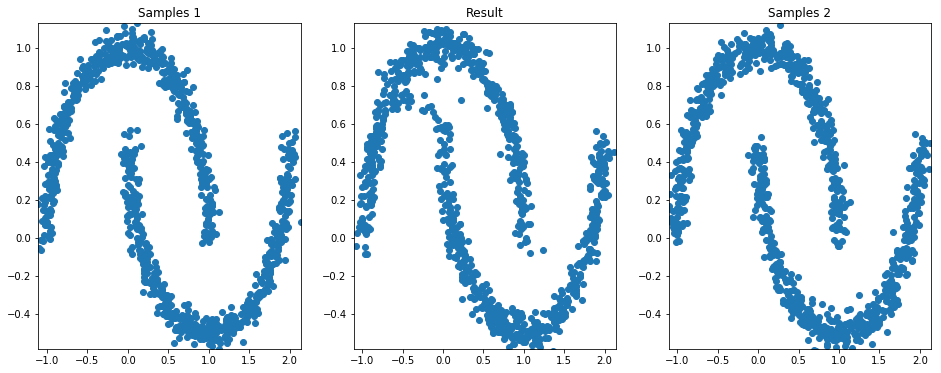

epoch 320: loss = 0.343 time = 3.31
Parameter containing:
tensor([6.2141e-02, 6.6174e-09], requires_grad=True)


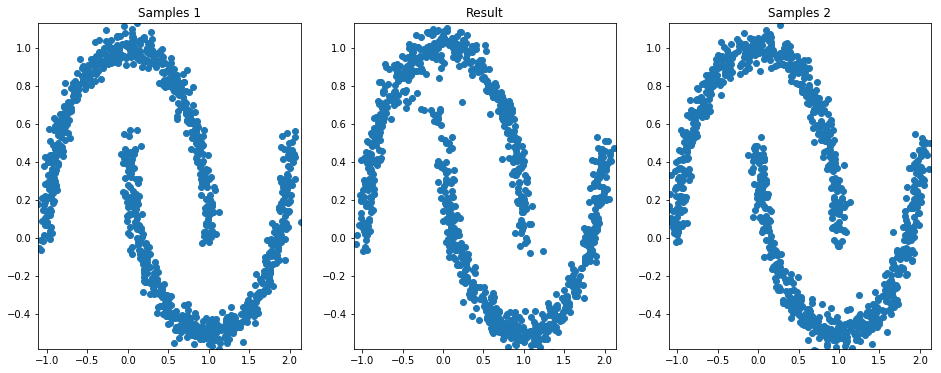

epoch 325: loss = 0.344 time = 3.33
Parameter containing:
tensor([5.6453e-02, 8.9210e-09], requires_grad=True)


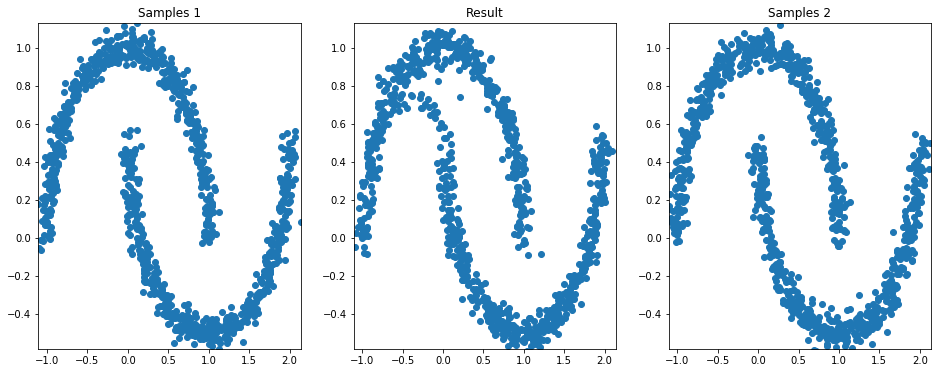

epoch 330: loss = 0.344 time = 3.23
Parameter containing:
tensor([5.9075e-02, 1.0220e-08], requires_grad=True)


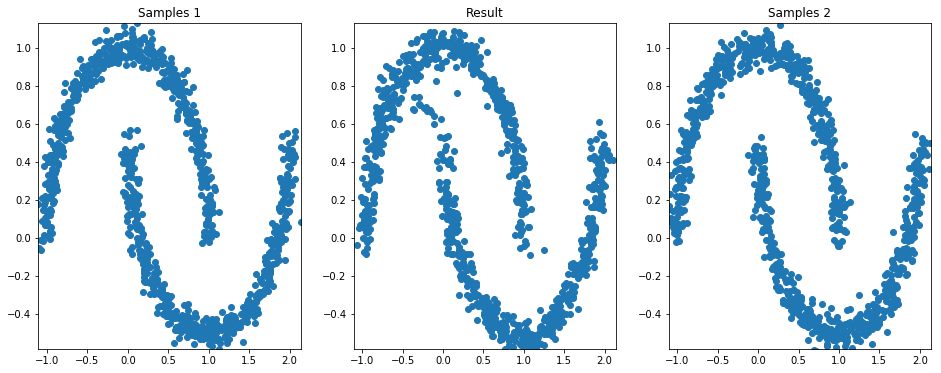

epoch 335: loss = 0.346 time = 3.09
Parameter containing:
tensor([5.9916e-02, 1.0871e-08], requires_grad=True)


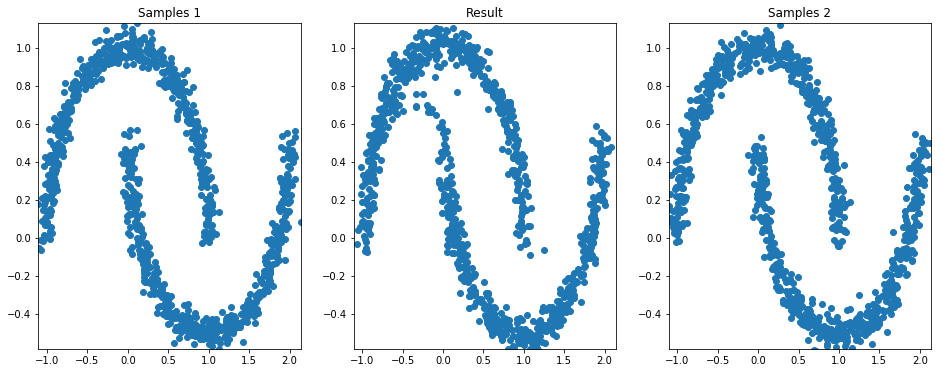

epoch 340: loss = 0.343 time = 3.10
Parameter containing:
tensor([6.1275e-02, 5.3218e-09], requires_grad=True)


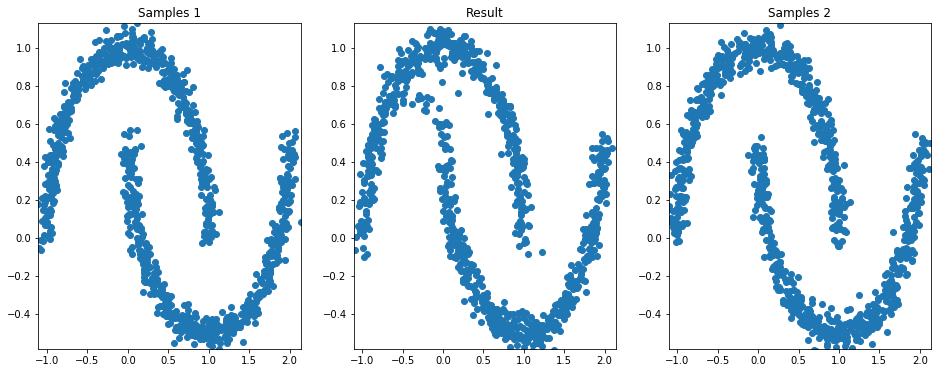

epoch 345: loss = 0.341 time = 3.36
Parameter containing:
tensor([6.0194e-02, 2.2892e-09], requires_grad=True)


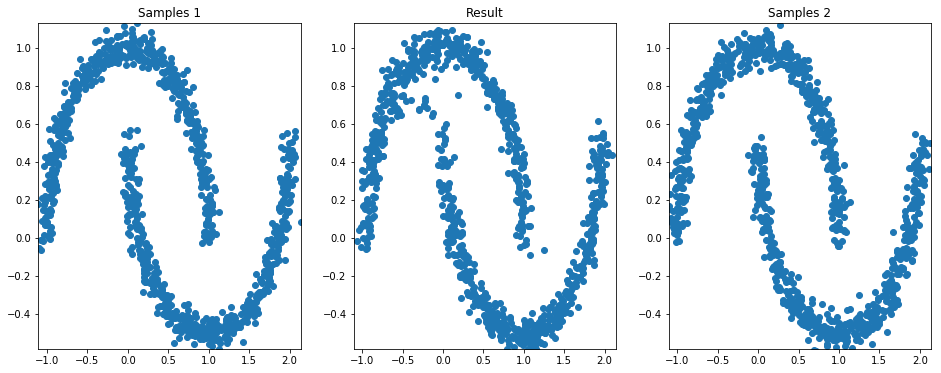

epoch 350: loss = 0.346 time = 3.37
Parameter containing:
tensor([5.6996e-02, 7.2859e-09], requires_grad=True)


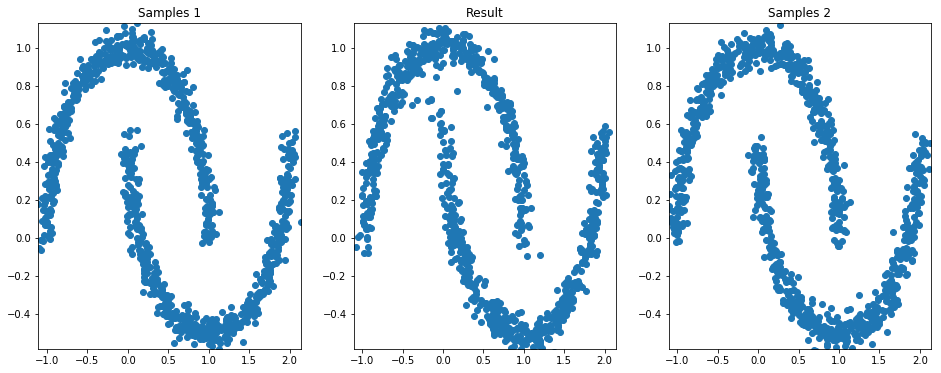

epoch 355: loss = 0.340 time = 3.35
Parameter containing:
tensor([5.8487e-02, 6.8638e-09], requires_grad=True)


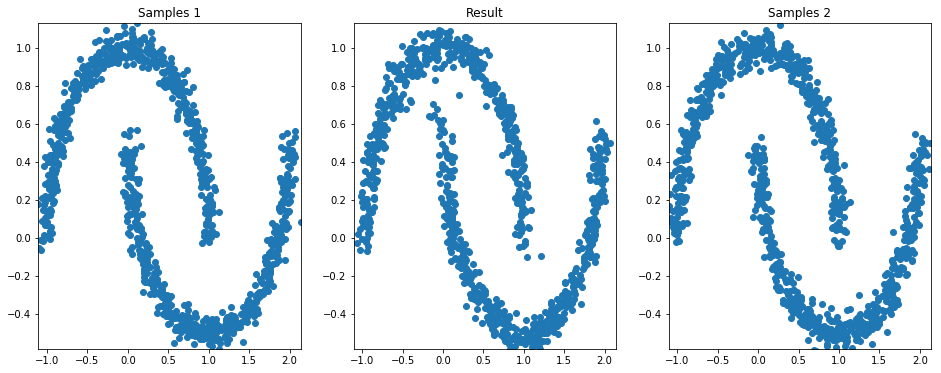

epoch 360: loss = 0.339 time = 3.35
Parameter containing:
tensor([6.1686e-02, 8.2343e-09], requires_grad=True)


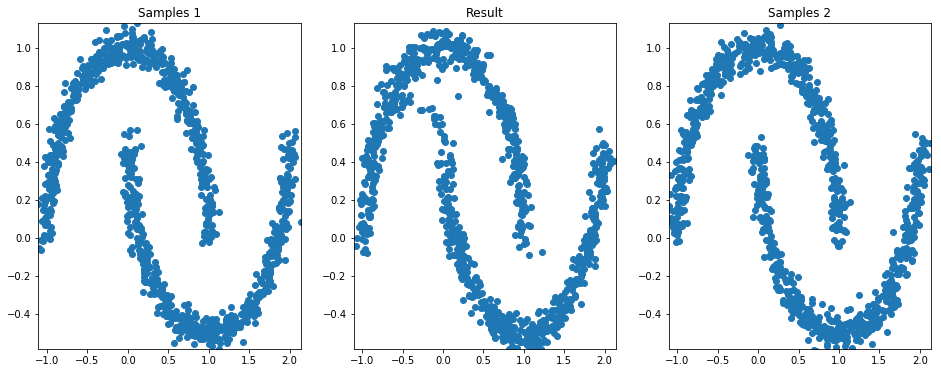

epoch 365: loss = 0.345 time = 3.41
Parameter containing:
tensor([6.0179e-02, 5.2939e-09], requires_grad=True)


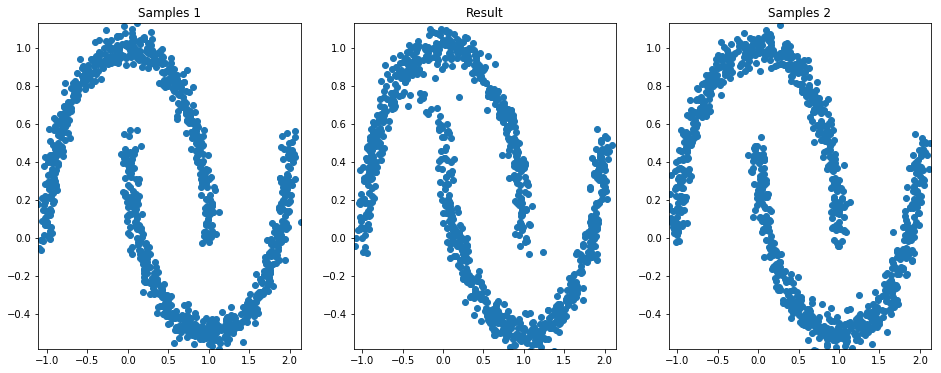

epoch 370: loss = 0.338 time = 3.31
Parameter containing:
tensor([6.1140e-02, 5.1571e-09], requires_grad=True)


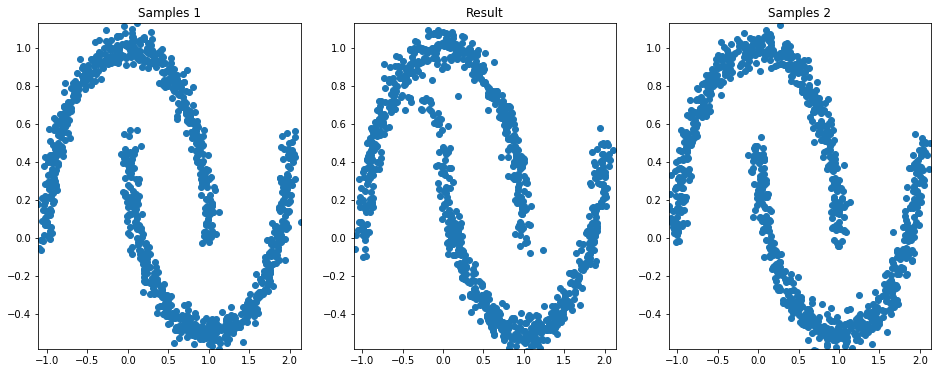

epoch 375: loss = 0.335 time = 3.41
Parameter containing:
tensor([6.0196e-02, 6.6493e-09], requires_grad=True)


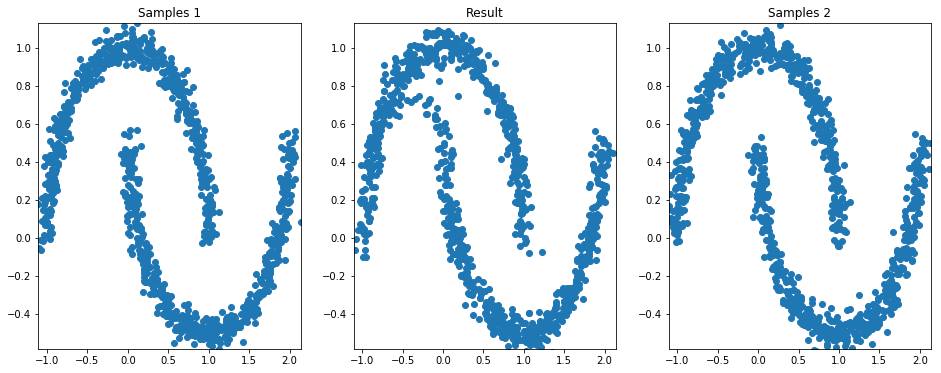

epoch 380: loss = 0.344 time = 3.37
Parameter containing:
tensor([5.8967e-02, 8.9742e-09], requires_grad=True)


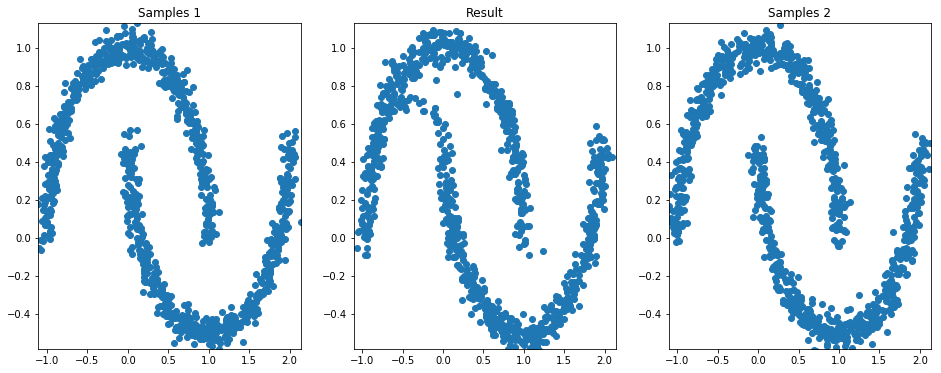

epoch 385: loss = 0.342 time = 3.30
Parameter containing:
tensor([6.1336e-02, 8.6188e-09], requires_grad=True)


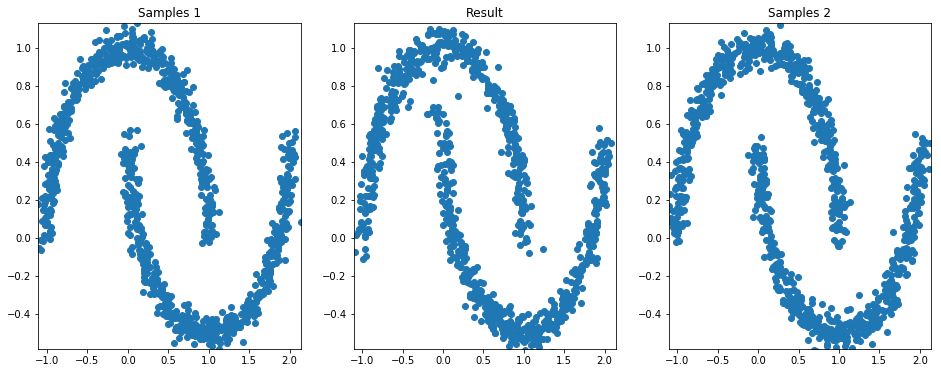

epoch 390: loss = 0.337 time = 3.40
Parameter containing:
tensor([6.0305e-02, 9.3952e-09], requires_grad=True)


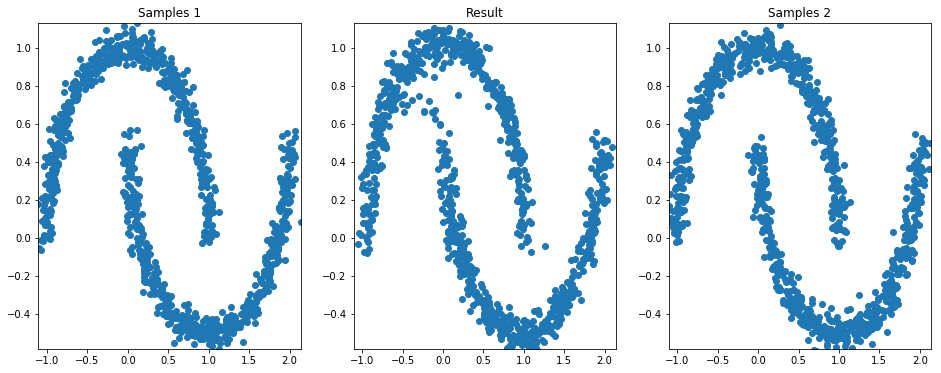

epoch 395: loss = 0.339 time = 3.26
Parameter containing:
tensor([5.9228e-02, 5.7343e-09], requires_grad=True)


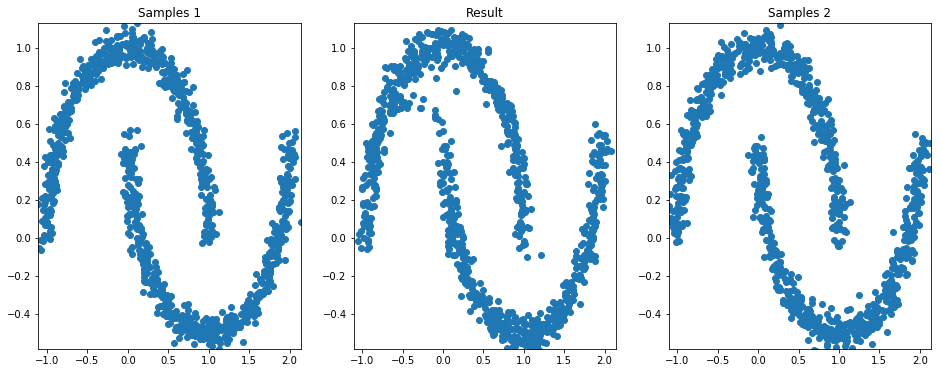

epoch 400: loss = 0.342 time = 3.33
Parameter containing:
tensor([6.0094e-02, 6.8845e-09], requires_grad=True)


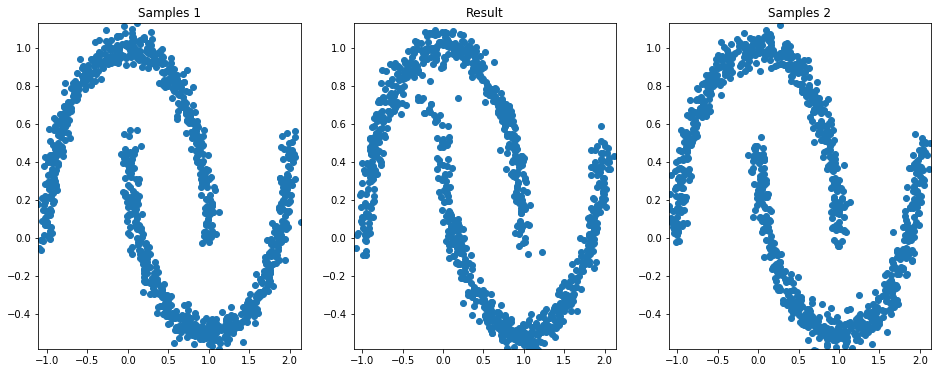

In [77]:
train(flow, epochs=400, lr=1e-4, batchsize=1000, step=5, start_epoch=1)

In [30]:
def transform(S1, S2, use_PSA=True, use_one=True, show=True, use_std=True, inverse=True, 
             use_third_cumulant=True, t=0.5, show_type='kde', K=2, use_flow=True):
    

    S = np.vstack([S1, S2])
    SI1 = S1
    SI2 = S2
    SI = S
    
    if use_flow:
        flow.cpu()
        for m in flow.b:
            m.mu.cpu()
            m.sig2.cpu()
        print(m.mu)
        S = flow.f(torch.FloatTensor(S)[0].data.cpu().numpy()
        S1 = flow.f(torch.FloatTensor(S1))[0].data.cpu().numpy()
        S2 = flow.f(torch.FloatTensor(S2))[0].data.cpu().numpy()
    
    mean = S.mean(0)
    S = S-mean
    S1 = S1-mean
    S2 = S2-mean
    
    if use_PSA:
        K = K
        transPSA = PCA(n_components = K)
        S = transPSA.fit_transform(S)
        S1 = transPSA.transform(S1)
        S2 = transPSA.transform(S2)

    if use_std:
        std = S.std(0)
        S = S/std
        S1 = S1/std
        S2 = S2/std
        
    if inverse:
        
        if use_one:
            TR1 = S
            TR2 = S
            TRF = S
        else:
            TR1 = S1
            TR2 = S2
            TRF = S
        
        pool = multiprocessing.Pool(200)
        res1 = np.array(pool.map(f, zip(S1.T, TR1.T))).T
        res2 = np.array(pool.map(f, zip(S2.T, TR2.T))).T

        rv = norm()

        nres1 = np.clip(rv.ppf(res1), -10, 10)
        nres2 =  np.clip(rv.ppf(res2), -10, 10)
    else:
        nres1, nres2 = S1, S2
        
    if use_third_cumulant:
        third_cumulants = compute_3cumulant(S)
    
    a = np.cos(np.pi*t/2)
    b = np.sin(np.pi*t/2)
    nfin = a*nres1+b*nres2
    
    if use_third_cumulant:
        delta = []
        for n1 in range(S.shape[1]):
            first = (np.diag(third_cumulants[n1])*(1-a-b)).sum(0) #- (np.diag(third_cumulants[n1])*(1-a-b))[n1]
#             first = 0
            second = 0
            for n2 in range(S.shape[1]):
                for n3 in range(S.shape[1]):
                    #if n3>=n2:
                        vsp = (a*nres1[:, n2]+b*nres2[:, n2])*(a*nres1[:, n3]+b*nres2[:, n3])
                        -a*nres1[:, n2]*nres1[:, n3]-b*nres2[:, n2]*nres2[:, n3]
                        second +=  third_cumulants[n1, n2, n3]*vsp

            delta.append(1/6*(-first+second))
        delta = np.array(delta).T

        nfin = nfin+delta
        
    if inverse:
        ufin = rv.cdf(nfin)
        fin = np.array(pool.map(g, zip(TRF.T, ufin.T))).T
    else:
        fin = nfin
    
    if use_std:
        fin = std*fin
    
    if use_PSA:
        fin = transPSA.inverse_transform(fin)
    
    fin +=mean
    
    if use_flow:
        fin = flow.g(torch.FloatTensor(fin)).data.cpu().numpy()
    
    show_samples(SI1, SI2, fin, show=show_type)
    
    if show and inverse:
        ind = 0
        rcParams['figure.dpi'] = 50
        plt.hist(SI2[:, ind], bins=30);
        plt.show()
        plt.hist(res2[:, ind], bins=30);
        plt.show()
        plt.hist(nres2[:, ind], bins = 50);
        plt.show()
        plt.hist(nfin[:, ind], bins = 50); 
        plt.show()
        plt.hist(ufin[:, ind], bins = 50); 
        plt.show()
        plt.hist(fin[:, ind], bins = 50);  
        plt.show()
        
    return fin